In [67]:
# Deep Convolutional GANs

# Importing the libraries
# from __future__ import print_function
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from torch.autograd.functional import hvp


import numpy as np
from mpi4py import MPI

from time import time, sleep

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda')

In [3]:
# Creating the network to create the peer2peer connection for swaping of the Discriminator

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

In [4]:
# Setting some hyperparameters
batchSize = 64 # We set the size of the batch.
imageSize = 64 # We set the size of the generated images (64x64).

In [5]:
# Creating the transformations
transform = transforms.Compose([transforms.Resize(imageSize), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]) # We create a list of transformations (scaling, tensor conversion, normalization) to apply to the input images.
#nc = 3

In [6]:
# Loading the dataset
dataset = dset.CIFAR10(root = './data', download = True, transform = transform)

Files already downloaded and verified


In [7]:
# We download the training set in the ./data folder and we apply the previous transformations on each image.
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batchSize, shuffle = True, num_workers = 2) 

In [8]:
""" 
We use dataLoader to get the images of the training set batch by batch.
We use the shuffle = True because we want to get the dataset in random order so that we can train model more precisely.
We use num_worker = 2 which represent the number of thread and the worker servers to define the 
"""

# Defining the weights_init function that takes as input a neural network m and that will initialize all its weights.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


In [9]:
# Defining the copy of the generator to shuffle between diffrent severs
def copyGenerator():
    layer_num = 0
    for param in netG.parameters():
        #print(rank, "started")
        if (rank == 0):
            data = param.data.numpy().copy()
            #print(rank, data.shape)
        else:
            data = None
            #print(rank, data.shape)

        #print(rank, "before bcast")
        #comm.Barrier()
        data = comm.bcast(data, root = 0)
        #print(rank, "after bcast")
        if (rank != 0):
            param.data = torch.from_numpy(data)
            #print("Node rank " + str(rank) + " has synched generator layer " + str(layer_num))

        layer_num += 1
        #comm.Barrier()

In [10]:
#Peer2Peer shuffling of the Discriminator
def shuffleDiscriminators():
    if (rank != 0):
        layer_num = 0
        for param in netD.parameters():
            outdata = param.data.numpy().copy()
            indata = None

            if (rank != size - 1):
                comm.send(outdata, dest=rank + 1, tag=1)
            if (rank != 1):
                indata = comm.recv(source = rank-1, tag=1)

            if (rank == size - 1):
                comm.send(outdata, dest=1, tag=2)
            if (rank == 1):
                indata = comm.recv(source = size - 1, tag=2)
            # Shuffling the Discriminator
            param.data = torch.from_numpy(indata)
            layer_num += 1

In [11]:
# Defining the generator

class G(nn.Module):

    def __init__(self):
        super(G, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias = False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias = False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias = False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias = False),
            nn.Tanh()
        )

    def forward(self, input):
        output = self.main(input)
        return output

In [12]:
# Creating the generator
netG = G()
netG.to(device)
netG.apply(weights_init)

G(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [13]:
# Defining the discriminator

class D(nn.Module):

    def __init__(self):
        super(D, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(64, 128, 4, 2, 1, bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(128, 256, 4, 2, 1, bias = False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(256, 512, 4, 2, 1, bias = False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(512, 1, 4, 1, 0, bias = False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1)


In [14]:
# Creating the discriminator
netD = D()
netD.to(device)
netD.apply(weights_init)

D(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [15]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(1024, 128)
        self.fc2 = nn.Linear(128, 12)
        
    def forward(self, x):
        out = self.fc1(x)
        out = out * out
        out = self.fc2(out)
        return out
    
    
model = Model()

In [16]:
class HEModel:
    def __init__(self, main):
        #self.main_weight = main.weight.t().tolist()
        self.main_weight = main.apply(weights_init)
        #self.main_bias = main.bias.tolist()
        self.main_bias = 1
        
    def forward(self, encrypted_vec):
        # first fc layer + square activation function
        encrypted_vec = encrypted_vec.mm(self.main_weight) + self.main_bias
        encrypted_vec *= encrypted_vec
        return encrypted_vec
    
    def __call__(self, x):
        return self.forward(x)

    
class HEModel:
    def __init__(self, fc1, fc2):
        self.fc1_weight = fc1.weight.t().tolist()
        self.fc1_bias = fc1.bias.tolist()
        self.fc2_weight = fc2.weight.t().tolist()
        self.fc2_bias = fc2.bias.tolist()
        
    def forward(self, encrypted_vec):
        # first fc layer + square activation function
        encrypted_vec = encrypted_vec.mm(self.fc1_weight) + self.fc1_bias
        encrypted_vec *= encrypted_vec
        # second fc layer
        encrypted_vec = encrypted_vec.mm(self.fc2_weight) + self.fc2_bias
        return encrypted_vec
    
    def __call__(self, x):
        return self.forward(x)

In [17]:
import tenseal as ts
import torch as th

# Parameters
bits_scale = 25
coeff_mod_bit_sizes = [30, bits_scale, bits_scale, bits_scale, 30]
#polynomial_modulus_degree = 32768
polynomial_modulus_degree = 8192

# Create context
context = ts.context(ts.SCHEME_TYPE.CKKS, polynomial_modulus_degree, coeff_mod_bit_sizes=coeff_mod_bit_sizes)
# Set global scale
context.global_scale = 2 ** bits_scale
# Generate galois keys required for matmul in ckks_vector
context.generate_galois_keys()

#netD_he_model = HEModel(netD.main)
#netG_he_model = HEModel(netG.main)

netD_he_model = HEModel(model.fc1, model.fc2)
netG_he_model = HEModel(model.fc1, model.fc2)

In [18]:
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr = 0.0002, betas = (0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr = 0.0002, betas = (0.5, 0.999))
no_of_epoch = 2

he_outs = []
t_start = time()

for epoch in range(no_of_epoch):

    if (epoch % 2 == 0):
        shuffleDiscriminators()

    for i, data in enumerate(dataloader, 775):
        
        
        # 1st Step: Updating the weights of the neural network of the discriminator

        netD.zero_grad()
        
        # Training the discriminator with a real image of the dataset
        real, _ = data
        input = Variable(real).to(device)
        #input = Variable(real)
        target = Variable(torch.ones(input.size()[0])).to(device)
        #target = Variable(torch.ones(input.size()[0]))
        output = netD(input).to(device)
        #output = netD(input)
        errD_real = criterion(output, target)
        
        # Training the discriminator with a fake image generated by the generator
        noise = Variable(torch.randn(input.size()[0], 100, 1, 1)).to(device)
        #noise = Variable(torch.randn(input.size()[0], 100, 1, 1))
        fake = netG(noise).to(device)
        #fake = netG(noise)model = ConvNet()
        
        target = Variable(torch.zeros(input.size()[0])).to(device)
        #target = Variable(torch.zeros(input.size()[0]))
        output = netD(fake.detach()).to(device)
        #output = netD(fake.detach())
    
        errD_fake = criterion(output, target)
        
        
        vec = real.flatten()
        encrypted_vec = ts.ckks_vector(context, vec)
        #encrypted_vec = ts.ckks_tensor(context, vec)
        #encrypted_out = netD_he_model(encrypted_vec)
        
        #he_out = th.tensor(encrypted_out.decrypt())
        he_out = th.tensor(encrypted_vec.decrypt())
        #he_outs.append(he_out.tolist())
        #out = model(data)
        
        
        
        # Backpropagating the total error
        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()

        # 2nd Step: Updating the weights of the neural network of the generator

        netG.zero_grad()
        target = Variable(torch.ones(input.size()[0])).to(device)
        #target = Variable(torch.ones(input.size()[0]))
        output = netD(fake).to(device)
        #output = netD(fake)
        errG = criterion(output, target)
        errG.backward()
        optimizerG.step()
        
        # 3rd Step: Printing the losses and saving the real images and the generated images of the minibatch every 100 steps

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' % (epoch, 25, i, len(dataloader), errD.item(), errG.item()))
        if i % 100 == 0:
            vutils.save_image(real, '%s/real_samples.png' % "./results", normalize = True)
            fake = netG(noise)
            vutils.save_image(fake.data, '%s/fake_samples_epoch_%03d.png' % ("./results", epoch), normalize = True)
                    
                
t_end = time()
print(f"Total training time took: {int(t_end - t_start)} seconds")

The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][775/782] Loss_D: 1.6693 Loss_G: 4.6061
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][776/782] Loss_D: 1.6442 Loss_G: 6.0162
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.


KeyboardInterrupt: 

In [19]:
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr = 0.0002, betas = (0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr = 0.0002, betas = (0.5, 0.999))
no_of_epoch = 1


def train():
    
    he_outs = []
    t_start = time()

    for epoch in range(no_of_epoch):

        if (epoch % 2 == 0):
            shuffleDiscriminators()

        for i, data in enumerate(dataloader, 775):


            # 1st Step: Updating the weights of the neural network of the discriminator

            netD.zero_grad()

            # Training the discriminator with a real image of the dataset
            real, _ = data
            input = Variable(real).to(device)
            #input = Variable(real)
            target = Variable(torch.ones(input.size()[0])).to(device)
            #target = Variable(torch.ones(input.size()[0]))
            output = netD(input).to(device)
            #output = netD(input)
            errD_real = criterion(output, target)

            # Training the discriminator with a fake image generated by the generator
            noise = Variable(torch.randn(input.size()[0], 100, 1, 1)).to(device)
            #noise = Variable(torch.randn(input.size()[0], 100, 1, 1))
            fake = netG(noise).to(device)
            #fake = netG(noise)
            target = Variable(torch.zeros(input.size()[0])).to(device)
            #target = Variable(torch.zeros(input.size()[0]))
            output = netD(fake.detach()).to(device)
            #output = netD(fake.detach())

            errD_fake = criterion(output, target)


            vec = real.flatten()
            encrypted_vec = ts.ckks_vector(context, vec)
            #encrypted_vec = ts.ckks_tensor(context, vec)
            #encrypted_out = netD_he_model(encrypted_vec)

            #he_out = th.tensor(encrypted_out.decrypt())
            he_out = th.tensor(encrypted_vec.decrypt())
            #he_outs.append(he_out.tolist())
            #out = model(data)



            # Backpropagating the total error
            errD = errD_real + errD_fake
            errD.backward()
            optimizerD.step()

            # 2nd Step: Updating the weights of the neural network of the generator

            netG.zero_grad()
            target = Variable(torch.ones(input.size()[0])).to(device)
            #target = Variable(torch.ones(input.size()[0]))
            output = netD(fake).to(device)
            #output = netD(fake)
            errG = criterion(output, target)
            errG.backward()
            optimizerG.step()

            # 3rd Step: Printing the losses and saving the real images and the generated images of the minibatch every 100 steps

            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' % (epoch, 25, i, len(dataloader), errD.item(), errG.item()))
            if i % 100 == 0:
                vutils.save_image(real, '%s/real_samples.png' % "./results", normalize = True)
                fake = netG(noise)
                vutils.save_image(fake.data, '%s/fake_samples_epoch_%03d.png' % ("./results", epoch), normalize = True)

    t_end = time()
    print(f"Total training time took: {int(t_end - t_start)} seconds")

In [20]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batchSize, shuffle = True, num_workers = 2) 
train()
sleep(10)

The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][775/782] Loss_D: 1.0796 Loss_G: 5.9025
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][776/782] Loss_D: 0.9120 Loss_G: 6.8277
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][777/782] Loss_D: 0.5276 Loss_G: 6.7975
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][778/782] Loss_D: 0.6837 Los

[0/25][798/782] Loss_D: 0.2658 Loss_G: 14.6911
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][799/782] Loss_D: 0.0973 Loss_G: 6.3649
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][800/782] Loss_D: 3.3236 Loss_G: 22.4103
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][801/782] Loss_D: 0.3740 Loss_G: 25.4005
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to f

[0/25][822/782] Loss_D: 1.7997 Loss_G: 23.2326
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][823/782] Loss_D: 0.5126 Loss_G: 18.9237
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][824/782] Loss_D: 0.1321 Loss_G: 11.6007
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][825/782] Loss_D: 0.1176 Loss_G: 5.5504
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to f

[0/25][846/782] Loss_D: 0.1624 Loss_G: 8.8173
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][847/782] Loss_D: 0.2362 Loss_G: 5.6427
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][848/782] Loss_D: 0.4643 Loss_G: 7.4309
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][849/782] Loss_D: 0.3313 Loss_G: 7.1024
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][870/782] Loss_D: 0.1929 Loss_G: 3.7831
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][871/782] Loss_D: 0.4247 Loss_G: 3.2747
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][872/782] Loss_D: 0.4022 Loss_G: 4.6828
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][873/782] Loss_D: 0.5040 Loss_G: 4.2464
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][894/782] Loss_D: 1.1717 Loss_G: 9.5498
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][895/782] Loss_D: 1.5653 Loss_G: 6.2714
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][896/782] Loss_D: 0.3452 Loss_G: 2.2487
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][897/782] Loss_D: 1.3849 Loss_G: 8.3710
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][918/782] Loss_D: 0.9472 Loss_G: 7.7457
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][919/782] Loss_D: 1.0860 Loss_G: 3.9694
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][920/782] Loss_D: 0.4142 Loss_G: 3.8137
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][921/782] Loss_D: 0.3607 Loss_G: 4.4638
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][942/782] Loss_D: 0.4801 Loss_G: 3.8286
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][943/782] Loss_D: 0.7419 Loss_G: 7.9223
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][944/782] Loss_D: 0.7312 Loss_G: 5.1254
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][945/782] Loss_D: 0.3273 Loss_G: 4.4444
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][966/782] Loss_D: 0.3525 Loss_G: 8.4969
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][967/782] Loss_D: 0.4977 Loss_G: 5.7211
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][968/782] Loss_D: 0.2185 Loss_G: 4.2454
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][969/782] Loss_D: 0.5021 Loss_G: 8.8457
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][990/782] Loss_D: 0.1482 Loss_G: 5.4508
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][991/782] Loss_D: 0.2119 Loss_G: 6.7135
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][992/782] Loss_D: 0.2025 Loss_G: 5.6722
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][993/782] Loss_D: 0.2356 Loss_G: 5.2179
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][1014/782] Loss_D: 0.1101 Loss_G: 4.8221
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1015/782] Loss_D: 0.4118 Loss_G: 10.6357
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1016/782] Loss_D: 0.2946 Loss_G: 9.5495
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1017/782] Loss_D: 0.2152 Loss_G: 6.0567
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to

[0/25][1038/782] Loss_D: 0.4170 Loss_G: 11.0127
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1039/782] Loss_D: 0.6669 Loss_G: 7.9614
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1040/782] Loss_D: 0.1272 Loss_G: 4.3837
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1041/782] Loss_D: 1.9479 Loss_G: 16.8464
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, t

[0/25][1062/782] Loss_D: 0.2268 Loss_G: 6.6256
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1063/782] Loss_D: 0.6559 Loss_G: 3.4639
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1064/782] Loss_D: 0.6962 Loss_G: 5.2850
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1065/782] Loss_D: 0.3450 Loss_G: 5.0656
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1086/782] Loss_D: 0.3418 Loss_G: 5.2356
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1087/782] Loss_D: 0.3045 Loss_G: 4.2139
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1088/782] Loss_D: 0.3936 Loss_G: 2.3763
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1089/782] Loss_D: 0.5221 Loss_G: 5.3226
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1110/782] Loss_D: 1.1205 Loss_G: 2.0589
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1111/782] Loss_D: 0.9232 Loss_G: 3.1850
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1112/782] Loss_D: 0.7094 Loss_G: 3.8755
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1113/782] Loss_D: 0.6719 Loss_G: 2.1963
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1134/782] Loss_D: 0.7783 Loss_G: 3.7269
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1135/782] Loss_D: 0.5770 Loss_G: 5.1169
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1136/782] Loss_D: 0.6637 Loss_G: 2.7919
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1137/782] Loss_D: 0.7533 Loss_G: 5.0486
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1158/782] Loss_D: 2.0196 Loss_G: 0.3022
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1159/782] Loss_D: 3.1500 Loss_G: 8.8433
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1160/782] Loss_D: 2.3670 Loss_G: 4.2983
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1161/782] Loss_D: 0.7788 Loss_G: 1.5063
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1182/782] Loss_D: 1.6368 Loss_G: 8.4291
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1183/782] Loss_D: 2.5717 Loss_G: 2.8061
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1184/782] Loss_D: 0.6909 Loss_G: 2.0339
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1185/782] Loss_D: 0.9440 Loss_G: 4.4766
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1206/782] Loss_D: 0.4246 Loss_G: 4.5573
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1207/782] Loss_D: 0.4769 Loss_G: 3.0933
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1208/782] Loss_D: 0.4143 Loss_G: 4.1737
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1209/782] Loss_D: 0.3297 Loss_G: 4.1419
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1230/782] Loss_D: 0.4277 Loss_G: 5.7441
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1231/782] Loss_D: 0.3659 Loss_G: 3.8043
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1232/782] Loss_D: 0.7677 Loss_G: 3.6013
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1233/782] Loss_D: 0.4970 Loss_G: 5.0386
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1254/782] Loss_D: 0.3967 Loss_G: 5.0047
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1255/782] Loss_D: 0.3684 Loss_G: 3.5767
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1256/782] Loss_D: 0.4682 Loss_G: 4.5335
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1257/782] Loss_D: 0.2546 Loss_G: 4.5187
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1278/782] Loss_D: 0.3617 Loss_G: 3.6744
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1279/782] Loss_D: 0.4717 Loss_G: 4.7272
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1280/782] Loss_D: 0.2797 Loss_G: 4.5661
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1281/782] Loss_D: 0.2097 Loss_G: 4.1639
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1302/782] Loss_D: 0.5254 Loss_G: 4.5421
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1303/782] Loss_D: 0.3667 Loss_G: 3.5738
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1304/782] Loss_D: 0.5863 Loss_G: 5.9695
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1305/782] Loss_D: 0.5145 Loss_G: 3.5913
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1326/782] Loss_D: 0.2514 Loss_G: 3.8869
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1327/782] Loss_D: 0.4150 Loss_G: 3.8571
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1328/782] Loss_D: 0.2704 Loss_G: 4.0792
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1329/782] Loss_D: 0.2312 Loss_G: 4.2620
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1350/782] Loss_D: 0.4036 Loss_G: 5.2134
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1351/782] Loss_D: 0.2700 Loss_G: 4.5113
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1352/782] Loss_D: 0.2743 Loss_G: 3.4884
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1353/782] Loss_D: 0.4488 Loss_G: 4.7339
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1374/782] Loss_D: 0.4623 Loss_G: 2.9057
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1375/782] Loss_D: 0.4939 Loss_G: 7.0190
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1376/782] Loss_D: 0.4000 Loss_G: 5.2125
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1377/782] Loss_D: 0.2440 Loss_G: 3.5153
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1398/782] Loss_D: 0.4717 Loss_G: 5.1999
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1399/782] Loss_D: 0.5246 Loss_G: 6.8708
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1400/782] Loss_D: 0.1844 Loss_G: 5.5816
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1401/782] Loss_D: 0.3488 Loss_G: 5.2253
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1422/782] Loss_D: 0.4598 Loss_G: 3.2213
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1423/782] Loss_D: 0.7574 Loss_G: 6.7093
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1424/782] Loss_D: 0.6600 Loss_G: 4.0612
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1425/782] Loss_D: 0.2421 Loss_G: 3.9746
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1446/782] Loss_D: 0.7521 Loss_G: 5.2022
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1447/782] Loss_D: 0.5757 Loss_G: 3.1495
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1448/782] Loss_D: 0.3834 Loss_G: 5.0136
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1449/782] Loss_D: 0.2731 Loss_G: 3.9286
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1470/782] Loss_D: 0.4059 Loss_G: 4.4309
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1471/782] Loss_D: 0.4547 Loss_G: 2.7708
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1472/782] Loss_D: 0.5325 Loss_G: 3.3060
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1473/782] Loss_D: 0.2636 Loss_G: 4.4203
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1494/782] Loss_D: 0.2999 Loss_G: 5.2747
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1495/782] Loss_D: 0.4478 Loss_G: 4.6540
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1496/782] Loss_D: 0.7425 Loss_G: 7.0846
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1497/782] Loss_D: 1.0278 Loss_G: 3.4523
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1518/782] Loss_D: 1.0575 Loss_G: 5.3913
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1519/782] Loss_D: 0.8700 Loss_G: 2.1510
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1520/782] Loss_D: 0.7340 Loss_G: 5.6899
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1521/782] Loss_D: 0.5510 Loss_G: 4.1640
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1542/782] Loss_D: 0.7409 Loss_G: 2.6824
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1543/782] Loss_D: 0.5710 Loss_G: 3.2616
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1544/782] Loss_D: 0.5072 Loss_G: 3.1696
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1545/782] Loss_D: 0.7638 Loss_G: 1.8928
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

In [21]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batchSize, shuffle = True, num_workers = 200) 
train()
sleep(10)

/home/captain/anaconda3/envs/GANIN/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 200 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][775/782] Loss_D: 0.9056 Loss_G: 6.0533
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][776/782] Loss_D: 1.0917 Loss_G: 2.3080
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][777/782] Loss_D: 0.7182 Loss_G: 4.2396
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][778/782] Loss_D: 0.3342 Los

[0/25][798/782] Loss_D: 1.2544 Loss_G: 0.9692
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][799/782] Loss_D: 1.6237 Loss_G: 6.3702
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][800/782] Loss_D: 2.0137 Loss_G: 2.1709
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][801/782] Loss_D: 0.8706 Loss_G: 3.8672
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][822/782] Loss_D: 0.4758 Loss_G: 3.1515
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][823/782] Loss_D: 0.9485 Loss_G: 1.5380
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][824/782] Loss_D: 1.0516 Loss_G: 4.3422
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][825/782] Loss_D: 0.6964 Loss_G: 2.3996
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][846/782] Loss_D: 0.5818 Loss_G: 3.1859
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][847/782] Loss_D: 0.3754 Loss_G: 4.4028
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][848/782] Loss_D: 0.4948 Loss_G: 4.1169
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][849/782] Loss_D: 0.5556 Loss_G: 3.6836
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][870/782] Loss_D: 1.1393 Loss_G: 4.2161
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][871/782] Loss_D: 0.7887 Loss_G: 2.4635
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][872/782] Loss_D: 0.7765 Loss_G: 3.6830
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][873/782] Loss_D: 0.7886 Loss_G: 2.3143
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][894/782] Loss_D: 0.5277 Loss_G: 3.2697
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][895/782] Loss_D: 0.4418 Loss_G: 3.4200
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][896/782] Loss_D: 0.7003 Loss_G: 3.2066
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][897/782] Loss_D: 0.8238 Loss_G: 1.5892
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][918/782] Loss_D: 0.3787 Loss_G: 3.0575
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][919/782] Loss_D: 0.4981 Loss_G: 2.2268
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][920/782] Loss_D: 0.7556 Loss_G: 4.9665
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][921/782] Loss_D: 0.7844 Loss_G: 2.1028
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][942/782] Loss_D: 0.3659 Loss_G: 4.1581
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][943/782] Loss_D: 0.2519 Loss_G: 3.7324
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][944/782] Loss_D: 0.2548 Loss_G: 4.0286
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][945/782] Loss_D: 0.3852 Loss_G: 2.9622
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][966/782] Loss_D: 0.6777 Loss_G: 3.5047
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][967/782] Loss_D: 0.6968 Loss_G: 4.2097
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][968/782] Loss_D: 0.4639 Loss_G: 4.2850
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][969/782] Loss_D: 0.3774 Loss_G: 3.5351
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][990/782] Loss_D: 0.4307 Loss_G: 5.8209
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][991/782] Loss_D: 0.7814 Loss_G: 1.4921
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][992/782] Loss_D: 1.4829 Loss_G: 9.0920
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][993/782] Loss_D: 1.5346 Loss_G: 2.7137
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][1014/782] Loss_D: 0.5021 Loss_G: 4.0254
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1015/782] Loss_D: 0.4469 Loss_G: 3.9005
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1016/782] Loss_D: 0.3934 Loss_G: 3.2275
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1017/782] Loss_D: 0.5267 Loss_G: 3.2922
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1038/782] Loss_D: 0.5687 Loss_G: 5.2417
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1039/782] Loss_D: 0.7558 Loss_G: 1.9170
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1040/782] Loss_D: 1.2358 Loss_G: 7.2688
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1041/782] Loss_D: 0.9109 Loss_G: 4.8044
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1062/782] Loss_D: 0.8469 Loss_G: 2.6980
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1063/782] Loss_D: 0.8591 Loss_G: 4.0216
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1064/782] Loss_D: 0.7073 Loss_G: 2.5567
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1065/782] Loss_D: 0.7412 Loss_G: 5.1069
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1086/782] Loss_D: 0.6223 Loss_G: 5.1334
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1087/782] Loss_D: 0.3686 Loss_G: 4.3155
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1088/782] Loss_D: 0.4521 Loss_G: 2.7968
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1089/782] Loss_D: 0.3747 Loss_G: 3.5290
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1110/782] Loss_D: 0.7352 Loss_G: 3.3314
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1111/782] Loss_D: 0.3914 Loss_G: 4.2003
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1112/782] Loss_D: 0.3530 Loss_G: 3.2189
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1113/782] Loss_D: 0.3333 Loss_G: 4.0571
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1134/782] Loss_D: 0.5697 Loss_G: 2.9539
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1135/782] Loss_D: 0.5580 Loss_G: 4.5524
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1136/782] Loss_D: 0.4040 Loss_G: 3.8315
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1137/782] Loss_D: 0.3220 Loss_G: 3.7743
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1158/782] Loss_D: 0.4502 Loss_G: 3.5630
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1159/782] Loss_D: 0.6130 Loss_G: 3.4158
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1160/782] Loss_D: 0.5088 Loss_G: 4.0050
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1161/782] Loss_D: 0.8926 Loss_G: 2.9568
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1182/782] Loss_D: 0.2907 Loss_G: 3.7013
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1183/782] Loss_D: 0.3439 Loss_G: 3.3404
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1184/782] Loss_D: 0.3761 Loss_G: 3.0024
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1185/782] Loss_D: 0.3887 Loss_G: 4.4725
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1206/782] Loss_D: 0.5947 Loss_G: 3.8979
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1207/782] Loss_D: 0.3557 Loss_G: 4.1176
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1208/782] Loss_D: 0.6096 Loss_G: 2.5131
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1209/782] Loss_D: 0.8752 Loss_G: 3.7689
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1230/782] Loss_D: 0.7383 Loss_G: 3.9270
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1231/782] Loss_D: 0.4954 Loss_G: 3.0354
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1232/782] Loss_D: 0.5539 Loss_G: 3.0987
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1233/782] Loss_D: 0.4687 Loss_G: 3.2084
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1254/782] Loss_D: 0.7615 Loss_G: 4.0348
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1255/782] Loss_D: 0.4649 Loss_G: 3.7348
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1256/782] Loss_D: 0.4094 Loss_G: 3.0027
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1257/782] Loss_D: 0.6172 Loss_G: 4.5379
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1278/782] Loss_D: 0.7869 Loss_G: 5.0080
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1279/782] Loss_D: 0.5398 Loss_G: 3.1129
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1280/782] Loss_D: 0.5583 Loss_G: 3.5415
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1281/782] Loss_D: 0.6705 Loss_G: 2.6768
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1302/782] Loss_D: 0.4649 Loss_G: 3.0287
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1303/782] Loss_D: 0.5068 Loss_G: 4.7199
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1304/782] Loss_D: 0.7585 Loss_G: 2.2688
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1305/782] Loss_D: 0.8018 Loss_G: 3.9574
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1326/782] Loss_D: 0.7859 Loss_G: 5.1254
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1327/782] Loss_D: 0.8468 Loss_G: 1.5489
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1328/782] Loss_D: 1.6259 Loss_G: 8.2839
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1329/782] Loss_D: 2.1712 Loss_G: 1.6013
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1350/782] Loss_D: 0.3855 Loss_G: 4.1665
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1351/782] Loss_D: 0.5638 Loss_G: 2.7535
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1352/782] Loss_D: 0.4880 Loss_G: 3.3814
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1353/782] Loss_D: 1.0696 Loss_G: 3.5627
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1374/782] Loss_D: 0.4550 Loss_G: 3.8683
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1375/782] Loss_D: 0.6234 Loss_G: 1.7136
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1376/782] Loss_D: 0.8182 Loss_G: 4.9636
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1377/782] Loss_D: 0.8558 Loss_G: 2.2203
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1398/782] Loss_D: 0.4449 Loss_G: 2.7855
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1399/782] Loss_D: 0.6433 Loss_G: 3.6752
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1400/782] Loss_D: 0.5382 Loss_G: 3.6329
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1401/782] Loss_D: 0.4225 Loss_G: 3.1753
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1422/782] Loss_D: 0.4652 Loss_G: 4.2682
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1423/782] Loss_D: 0.7792 Loss_G: 3.3835
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1424/782] Loss_D: 0.9426 Loss_G: 3.0615
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1425/782] Loss_D: 0.6424 Loss_G: 4.9707
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1446/782] Loss_D: 0.6265 Loss_G: 3.8698
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1447/782] Loss_D: 0.2549 Loss_G: 3.2569
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1448/782] Loss_D: 0.3743 Loss_G: 4.0423
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1449/782] Loss_D: 0.2706 Loss_G: 4.0493
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1470/782] Loss_D: 0.6136 Loss_G: 1.9210
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1471/782] Loss_D: 1.2703 Loss_G: 6.3944
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1472/782] Loss_D: 1.3237 Loss_G: 2.7227
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1473/782] Loss_D: 0.6156 Loss_G: 2.7575
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1494/782] Loss_D: 0.4965 Loss_G: 3.2539
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1495/782] Loss_D: 0.5347 Loss_G: 2.8612
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1496/782] Loss_D: 0.4093 Loss_G: 2.8652
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1497/782] Loss_D: 0.3725 Loss_G: 3.4434
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1518/782] Loss_D: 0.7403 Loss_G: 2.2484
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1519/782] Loss_D: 0.6566 Loss_G: 4.0830
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1520/782] Loss_D: 0.4156 Loss_G: 3.4804
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1521/782] Loss_D: 0.4427 Loss_G: 2.9909
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1542/782] Loss_D: 0.5076 Loss_G: 3.1794
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1543/782] Loss_D: 0.6423 Loss_G: 3.4540
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1544/782] Loss_D: 0.4907 Loss_G: 2.8506
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1545/782] Loss_D: 1.0289 Loss_G: 3.2022
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

In [19]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batchSize, shuffle = True, num_workers = 300) 
train()
sleep(10)

/home/captain/anaconda3/envs/GANIN/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 300 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][775/782] Loss_D: 2.0411 Loss_G: 5.7920
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][776/782] Loss_D: 1.2395 Loss_G: 5.4198
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][777/782] Loss_D: 0.8350 Loss_G: 6.3277
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][778/782] Loss_D: 0.9512 Los

[0/25][798/782] Loss_D: 3.7480 Loss_G: 19.5772
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][799/782] Loss_D: 0.4352 Loss_G: 20.9915
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][800/782] Loss_D: 0.3419 Loss_G: 16.4160
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][801/782] Loss_D: 0.4222 Loss_G: 6.8291
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to f

[0/25][822/782] Loss_D: 1.2650 Loss_G: 17.4315
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][823/782] Loss_D: 0.1110 Loss_G: 19.4091
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][824/782] Loss_D: 0.1123 Loss_G: 16.9387
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][825/782] Loss_D: 0.1684 Loss_G: 11.5156
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][846/782] Loss_D: 0.0808 Loss_G: 4.8793
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][847/782] Loss_D: 2.2542 Loss_G: 21.2238
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][848/782] Loss_D: 0.6224 Loss_G: 23.5783
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][849/782] Loss_D: 0.3638 Loss_G: 20.5720
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to f

[0/25][870/782] Loss_D: 0.3348 Loss_G: 8.7531
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][871/782] Loss_D: 0.1372 Loss_G: 8.0944
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][872/782] Loss_D: 0.1691 Loss_G: 5.8531
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][873/782] Loss_D: 0.4083 Loss_G: 8.7310
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][894/782] Loss_D: 0.2412 Loss_G: 4.7824
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][895/782] Loss_D: 0.4161 Loss_G: 3.8217
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][896/782] Loss_D: 0.3170 Loss_G: 4.9803
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][897/782] Loss_D: 0.2952 Loss_G: 4.4329
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][918/782] Loss_D: 0.2134 Loss_G: 4.3123
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][919/782] Loss_D: 0.3615 Loss_G: 4.2353
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][920/782] Loss_D: 0.4189 Loss_G: 3.2000
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][921/782] Loss_D: 0.6091 Loss_G: 7.1941
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][942/782] Loss_D: 0.5398 Loss_G: 6.2967
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][943/782] Loss_D: 1.0028 Loss_G: 2.0782
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][944/782] Loss_D: 1.1186 Loss_G: 8.3512
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][945/782] Loss_D: 0.8730 Loss_G: 6.7863
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][966/782] Loss_D: 1.1743 Loss_G: 4.8878
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][967/782] Loss_D: 0.6855 Loss_G: 5.9709
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][968/782] Loss_D: 0.5653 Loss_G: 5.9420
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][969/782] Loss_D: 0.2096 Loss_G: 5.7169
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][990/782] Loss_D: 0.4084 Loss_G: 5.0914
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][991/782] Loss_D: 0.4536 Loss_G: 2.9847
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][992/782] Loss_D: 0.5625 Loss_G: 6.6536
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][993/782] Loss_D: 0.4446 Loss_G: 4.7961
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][1014/782] Loss_D: 0.1678 Loss_G: 4.6368
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1015/782] Loss_D: 0.1624 Loss_G: 4.3686
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1016/782] Loss_D: 0.1609 Loss_G: 5.1014
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1017/782] Loss_D: 0.1412 Loss_G: 5.0839
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1038/782] Loss_D: 0.0359 Loss_G: 5.2630
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1039/782] Loss_D: 0.7347 Loss_G: 17.2522
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1040/782] Loss_D: 0.5150 Loss_G: 17.8780
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1041/782] Loss_D: 0.4527 Loss_G: 12.5794
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, 

[0/25][1062/782] Loss_D: 0.5485 Loss_G: 5.2567
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1063/782] Loss_D: 0.5037 Loss_G: 14.0843
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1064/782] Loss_D: 0.4984 Loss_G: 11.9494
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1065/782] Loss_D: 0.0606 Loss_G: 8.4471
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, t

[0/25][1086/782] Loss_D: 0.1790 Loss_G: 4.7833
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1087/782] Loss_D: 0.1597 Loss_G: 4.6296
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1088/782] Loss_D: 0.1317 Loss_G: 4.4461
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1089/782] Loss_D: 0.1739 Loss_G: 4.4097
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1110/782] Loss_D: 0.1267 Loss_G: 5.4388
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1111/782] Loss_D: 0.1159 Loss_G: 5.3250
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1112/782] Loss_D: 0.1168 Loss_G: 5.5330
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1113/782] Loss_D: 0.3502 Loss_G: 3.2572
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1134/782] Loss_D: 0.6815 Loss_G: 6.3728
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1135/782] Loss_D: 0.1545 Loss_G: 6.7125
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1136/782] Loss_D: 0.3268 Loss_G: 3.7803
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1137/782] Loss_D: 0.4556 Loss_G: 5.4077
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1158/782] Loss_D: 0.6809 Loss_G: 3.3152
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1159/782] Loss_D: 0.8517 Loss_G: 3.4981
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1160/782] Loss_D: 0.6641 Loss_G: 3.9889
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1161/782] Loss_D: 0.8551 Loss_G: 1.8612
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1182/782] Loss_D: 0.4814 Loss_G: 2.4072
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1183/782] Loss_D: 0.6736 Loss_G: 3.0607
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1184/782] Loss_D: 0.5896 Loss_G: 2.9617
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1185/782] Loss_D: 0.5850 Loss_G: 2.8193
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1206/782] Loss_D: 0.4821 Loss_G: 4.1096
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1207/782] Loss_D: 0.4911 Loss_G: 3.0806
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1208/782] Loss_D: 0.8474 Loss_G: 5.5553
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1209/782] Loss_D: 0.9081 Loss_G: 2.9038
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1230/782] Loss_D: 0.7164 Loss_G: 3.6260
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1231/782] Loss_D: 0.3866 Loss_G: 5.4327
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1232/782] Loss_D: 0.3548 Loss_G: 3.2592
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1233/782] Loss_D: 0.8837 Loss_G: 5.9094
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1254/782] Loss_D: 0.5396 Loss_G: 3.0448
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1255/782] Loss_D: 0.3004 Loss_G: 3.4504
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1256/782] Loss_D: 0.3335 Loss_G: 3.5395
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1257/782] Loss_D: 0.4267 Loss_G: 2.8318
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1278/782] Loss_D: 0.2135 Loss_G: 4.4507
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1279/782] Loss_D: 0.2398 Loss_G: 5.2610
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1280/782] Loss_D: 0.3183 Loss_G: 3.3096
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1281/782] Loss_D: 0.5945 Loss_G: 9.3753
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1302/782] Loss_D: 0.1246 Loss_G: 5.6191
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1303/782] Loss_D: 0.3162 Loss_G: 3.1454
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1304/782] Loss_D: 0.5498 Loss_G: 6.5647
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1305/782] Loss_D: 0.2212 Loss_G: 6.4604
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1326/782] Loss_D: 0.4245 Loss_G: 3.2736
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1327/782] Loss_D: 0.4171 Loss_G: 3.3175
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1328/782] Loss_D: 0.3504 Loss_G: 5.2361
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1329/782] Loss_D: 0.3804 Loss_G: 4.0993
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1350/782] Loss_D: 0.3966 Loss_G: 5.3312
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1351/782] Loss_D: 0.5498 Loss_G: 2.8874
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1352/782] Loss_D: 1.5855 Loss_G: 9.8892
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1353/782] Loss_D: 5.3691 Loss_G: 2.6658
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1374/782] Loss_D: 0.4101 Loss_G: 5.2522
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1375/782] Loss_D: 0.3429 Loss_G: 5.0102
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1376/782] Loss_D: 0.2848 Loss_G: 5.0901
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1377/782] Loss_D: 0.4590 Loss_G: 3.2041
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1398/782] Loss_D: 1.1995 Loss_G: 8.2464
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1399/782] Loss_D: 1.3473 Loss_G: 3.9195
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1400/782] Loss_D: 0.4555 Loss_G: 2.5731
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1401/782] Loss_D: 0.9654 Loss_G: 7.2057
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1422/782] Loss_D: 0.7004 Loss_G: 2.3471
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1423/782] Loss_D: 0.8703 Loss_G: 5.4362
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1424/782] Loss_D: 1.0948 Loss_G: 2.3350
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1425/782] Loss_D: 0.7717 Loss_G: 4.7591
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1446/782] Loss_D: 0.8162 Loss_G: 5.0107
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1447/782] Loss_D: 0.9812 Loss_G: 2.9797
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1448/782] Loss_D: 0.7119 Loss_G: 2.6020
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1449/782] Loss_D: 0.3557 Loss_G: 3.4491
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1470/782] Loss_D: 0.7315 Loss_G: 3.1756
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1471/782] Loss_D: 0.6430 Loss_G: 2.6289
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1472/782] Loss_D: 0.9088 Loss_G: 4.3547
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1473/782] Loss_D: 0.7609 Loss_G: 2.6885
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1494/782] Loss_D: 1.7961 Loss_G: 0.1996
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1495/782] Loss_D: 3.1639 Loss_G: 7.0751
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1496/782] Loss_D: 1.2430 Loss_G: 4.4983
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1497/782] Loss_D: 0.8488 Loss_G: 1.4845
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1518/782] Loss_D: 0.4259 Loss_G: 4.1982
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1519/782] Loss_D: 0.6563 Loss_G: 2.4884
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1520/782] Loss_D: 0.4948 Loss_G: 3.9394
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1521/782] Loss_D: 0.4458 Loss_G: 4.0116
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1542/782] Loss_D: 0.8538 Loss_G: 2.8849
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1543/782] Loss_D: 0.7849 Loss_G: 2.7814
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1544/782] Loss_D: 1.1320 Loss_G: 4.7770
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1545/782] Loss_D: 0.8216 Loss_G: 2.6481
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

In [20]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batchSize, shuffle = True, num_workers = 400) 
train()
sleep(10)

/home/captain/anaconda3/envs/GANIN/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 400 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][775/782] Loss_D: 1.2312 Loss_G: 5.4546
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][776/782] Loss_D: 1.0332 Loss_G: 2.4743
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][777/782] Loss_D: 1.2136 Loss_G: 3.2133
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][778/782] Loss_D: 0.9435 Los

[0/25][798/782] Loss_D: 0.1748 Loss_G: 4.6158
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][799/782] Loss_D: 0.3838 Loss_G: 2.9865
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][800/782] Loss_D: 0.3632 Loss_G: 4.5953
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][801/782] Loss_D: 0.3050 Loss_G: 3.7752
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][822/782] Loss_D: 2.9476 Loss_G: 1.6430
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][823/782] Loss_D: 1.4107 Loss_G: 2.8294
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][824/782] Loss_D: 0.9932 Loss_G: 2.7586
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][825/782] Loss_D: 1.8249 Loss_G: 1.9042
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][846/782] Loss_D: 0.7768 Loss_G: 2.2714
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][847/782] Loss_D: 0.7132 Loss_G: 4.1422
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][848/782] Loss_D: 0.8822 Loss_G: 2.4929
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][849/782] Loss_D: 0.4955 Loss_G: 4.1252
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][870/782] Loss_D: 0.3190 Loss_G: 3.8549
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][871/782] Loss_D: 0.4040 Loss_G: 3.5209
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][872/782] Loss_D: 0.4054 Loss_G: 3.7566
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][873/782] Loss_D: 0.3766 Loss_G: 4.2517
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][894/782] Loss_D: 0.8523 Loss_G: 5.6735
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][895/782] Loss_D: 0.6478 Loss_G: 3.2862
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][896/782] Loss_D: 0.5239 Loss_G: 2.2632
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][897/782] Loss_D: 0.8684 Loss_G: 5.9228
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][918/782] Loss_D: 0.2408 Loss_G: 3.7554
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][919/782] Loss_D: 0.2635 Loss_G: 4.6916
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][920/782] Loss_D: 0.4346 Loss_G: 1.8248
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][921/782] Loss_D: 1.0282 Loss_G: 6.8390
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][942/782] Loss_D: 1.7026 Loss_G: 4.9347
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][943/782] Loss_D: 1.0222 Loss_G: 2.7318
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][944/782] Loss_D: 1.2255 Loss_G: 2.9175
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][945/782] Loss_D: 0.7172 Loss_G: 3.7018
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][966/782] Loss_D: 0.4340 Loss_G: 3.5241
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][967/782] Loss_D: 0.5907 Loss_G: 3.9283
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][968/782] Loss_D: 0.7391 Loss_G: 2.0054
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][969/782] Loss_D: 0.9544 Loss_G: 7.5619
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][990/782] Loss_D: 0.2480 Loss_G: 4.5868
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][991/782] Loss_D: 0.2976 Loss_G: 3.0335
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][992/782] Loss_D: 0.3323 Loss_G: 3.8267
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][993/782] Loss_D: 0.2843 Loss_G: 4.0910
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][1014/782] Loss_D: 0.7827 Loss_G: 3.7939
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1015/782] Loss_D: 0.4491 Loss_G: 3.6131
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1016/782] Loss_D: 0.4741 Loss_G: 2.6905
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1017/782] Loss_D: 0.5529 Loss_G: 4.7725
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1038/782] Loss_D: 0.2505 Loss_G: 3.9986
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1039/782] Loss_D: 0.6708 Loss_G: 6.2012
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1040/782] Loss_D: 1.2396 Loss_G: 2.0966
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1041/782] Loss_D: 1.3882 Loss_G: 6.9449
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1062/782] Loss_D: 0.7005 Loss_G: 4.4512
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1063/782] Loss_D: 0.7723 Loss_G: 2.6695
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1064/782] Loss_D: 0.8881 Loss_G: 3.5221
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1065/782] Loss_D: 0.8846 Loss_G: 3.1044
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1086/782] Loss_D: 0.4819 Loss_G: 3.6454
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1087/782] Loss_D: 0.4507 Loss_G: 3.2710
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1088/782] Loss_D: 0.4660 Loss_G: 4.2309
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1089/782] Loss_D: 0.4625 Loss_G: 2.7773
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1110/782] Loss_D: 0.4382 Loss_G: 5.0073
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1111/782] Loss_D: 0.3009 Loss_G: 3.5147
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1112/782] Loss_D: 0.3080 Loss_G: 5.3100
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1113/782] Loss_D: 0.1943 Loss_G: 4.0021
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1134/782] Loss_D: 0.9118 Loss_G: 7.9047
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1135/782] Loss_D: 1.3606 Loss_G: 3.2850
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1136/782] Loss_D: 0.4720 Loss_G: 5.1041
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1137/782] Loss_D: 0.2828 Loss_G: 3.8744
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1158/782] Loss_D: 0.2929 Loss_G: 4.1958
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1159/782] Loss_D: 0.4262 Loss_G: 2.8921
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1160/782] Loss_D: 0.5142 Loss_G: 6.7657
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1161/782] Loss_D: 0.9810 Loss_G: 2.7007
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1182/782] Loss_D: 2.3733 Loss_G: 1.8805
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1183/782] Loss_D: 1.4457 Loss_G: 4.9110
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1184/782] Loss_D: 0.4352 Loss_G: 4.8212
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1185/782] Loss_D: 0.3809 Loss_G: 3.6013
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1206/782] Loss_D: 1.0226 Loss_G: 1.5039
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1207/782] Loss_D: 1.0940 Loss_G: 6.6889
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1208/782] Loss_D: 0.3076 Loss_G: 5.4826
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1209/782] Loss_D: 0.4598 Loss_G: 2.7930
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1230/782] Loss_D: 0.9843 Loss_G: 1.7478
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1231/782] Loss_D: 0.8094 Loss_G: 5.6878
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1232/782] Loss_D: 0.5261 Loss_G: 3.4699
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1233/782] Loss_D: 0.3408 Loss_G: 3.8306
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1254/782] Loss_D: 0.3428 Loss_G: 3.4202
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1255/782] Loss_D: 0.3415 Loss_G: 3.8924
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1256/782] Loss_D: 0.5596 Loss_G: 4.4054
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1257/782] Loss_D: 0.4119 Loss_G: 2.3285
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1278/782] Loss_D: 0.5368 Loss_G: 4.6466
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1279/782] Loss_D: 0.7997 Loss_G: 2.5332
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1280/782] Loss_D: 0.5114 Loss_G: 3.7197
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1281/782] Loss_D: 0.5685 Loss_G: 3.0019
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1302/782] Loss_D: 0.9597 Loss_G: 5.7481
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1303/782] Loss_D: 0.4910 Loss_G: 3.6043
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1304/782] Loss_D: 0.4963 Loss_G: 2.1395
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1305/782] Loss_D: 1.2376 Loss_G: 7.8958
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1326/782] Loss_D: 0.3617 Loss_G: 3.3445
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1327/782] Loss_D: 0.4472 Loss_G: 3.9221
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1328/782] Loss_D: 0.3719 Loss_G: 3.5921
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1329/782] Loss_D: 0.4229 Loss_G: 2.5157
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1350/782] Loss_D: 0.4127 Loss_G: 3.2521
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1351/782] Loss_D: 0.4575 Loss_G: 3.1560
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1352/782] Loss_D: 0.4863 Loss_G: 4.2694
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1353/782] Loss_D: 0.4702 Loss_G: 4.2790
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1374/782] Loss_D: 0.5149 Loss_G: 3.8604
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1375/782] Loss_D: 0.4932 Loss_G: 3.0561
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1376/782] Loss_D: 0.5649 Loss_G: 5.2540
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1377/782] Loss_D: 0.3770 Loss_G: 3.2020
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1398/782] Loss_D: 0.4201 Loss_G: 2.8382
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1399/782] Loss_D: 1.0209 Loss_G: 6.9915
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1400/782] Loss_D: 1.2458 Loss_G: 2.3151
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1401/782] Loss_D: 0.6816 Loss_G: 4.3956
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1422/782] Loss_D: 0.7905 Loss_G: 1.7228
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1423/782] Loss_D: 0.8055 Loss_G: 5.1983
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1424/782] Loss_D: 0.7703 Loss_G: 1.6864
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1425/782] Loss_D: 1.2653 Loss_G: 5.5783
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1446/782] Loss_D: 0.4774 Loss_G: 4.1816
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1447/782] Loss_D: 0.6282 Loss_G: 2.1913
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1448/782] Loss_D: 1.0173 Loss_G: 5.9763
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1449/782] Loss_D: 1.3580 Loss_G: 2.2241
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1470/782] Loss_D: 0.6558 Loss_G: 6.6229
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1471/782] Loss_D: 1.4700 Loss_G: 1.4322
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1472/782] Loss_D: 1.4888 Loss_G: 5.6191
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1473/782] Loss_D: 1.0938 Loss_G: 3.0523
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1494/782] Loss_D: 0.5620 Loss_G: 3.5958
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1495/782] Loss_D: 0.4074 Loss_G: 2.8429
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1496/782] Loss_D: 0.7432 Loss_G: 4.5125
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1497/782] Loss_D: 0.9649 Loss_G: 1.9224
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1518/782] Loss_D: 0.3361 Loss_G: 3.3934
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1519/782] Loss_D: 0.8793 Loss_G: 3.3456
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1520/782] Loss_D: 1.2939 Loss_G: 2.0821
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1521/782] Loss_D: 1.4013 Loss_G: 6.0368
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1542/782] Loss_D: 0.5351 Loss_G: 3.1646
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1543/782] Loss_D: 0.8658 Loss_G: 3.9964
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1544/782] Loss_D: 0.4612 Loss_G: 3.0197
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1545/782] Loss_D: 0.5309 Loss_G: 4.7556
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

In [21]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batchSize, shuffle = True, num_workers = 500) 
train()
sleep(10)

/home/captain/anaconda3/envs/GANIN/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 500 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][775/782] Loss_D: 0.6524 Loss_G: 4.6040
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][776/782] Loss_D: 0.9044 Loss_G: 2.2941
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][777/782] Loss_D: 0.6675 Loss_G: 3.5461
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][778/782] Loss_D: 0.4476 Los

[0/25][798/782] Loss_D: 0.5961 Loss_G: 2.5049
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][799/782] Loss_D: 0.7421 Loss_G: 4.6002
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][800/782] Loss_D: 0.7543 Loss_G: 2.1276
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][801/782] Loss_D: 0.7998 Loss_G: 3.4111
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][822/782] Loss_D: 1.3563 Loss_G: 5.7950
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][823/782] Loss_D: 1.4195 Loss_G: 2.5677
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][824/782] Loss_D: 0.5786 Loss_G: 3.1117
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][825/782] Loss_D: 0.5762 Loss_G: 4.9788
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][846/782] Loss_D: 0.4875 Loss_G: 3.3148
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][847/782] Loss_D: 0.4183 Loss_G: 4.0606
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][848/782] Loss_D: 0.4504 Loss_G: 2.3315
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][849/782] Loss_D: 0.5465 Loss_G: 4.6947
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][870/782] Loss_D: 1.4917 Loss_G: 1.0908
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][871/782] Loss_D: 0.8060 Loss_G: 5.0418
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][872/782] Loss_D: 0.4696 Loss_G: 3.1938
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][873/782] Loss_D: 0.5317 Loss_G: 3.0588
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][894/782] Loss_D: 0.7567 Loss_G: 4.2695
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][895/782] Loss_D: 0.6439 Loss_G: 2.5658
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][896/782] Loss_D: 0.8355 Loss_G: 2.9934
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][897/782] Loss_D: 0.5461 Loss_G: 3.7283
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][918/782] Loss_D: 0.5408 Loss_G: 4.6499
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][919/782] Loss_D: 0.7346 Loss_G: 2.0213
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][920/782] Loss_D: 0.8551 Loss_G: 4.4059
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][921/782] Loss_D: 0.5919 Loss_G: 3.0066
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][942/782] Loss_D: 1.5280 Loss_G: 1.4745
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][943/782] Loss_D: 1.1670 Loss_G: 3.5425
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][944/782] Loss_D: 0.5204 Loss_G: 3.6867
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][945/782] Loss_D: 0.4898 Loss_G: 2.7441
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][966/782] Loss_D: 0.6724 Loss_G: 3.8627
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][967/782] Loss_D: 0.5783 Loss_G: 2.6426
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][968/782] Loss_D: 0.4906 Loss_G: 2.8787
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][969/782] Loss_D: 0.6016 Loss_G: 2.6073
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][990/782] Loss_D: 2.2484 Loss_G: 5.6298
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][991/782] Loss_D: 3.1040 Loss_G: 1.4046
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][992/782] Loss_D: 1.1821 Loss_G: 1.7524
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][993/782] Loss_D: 0.6217 Loss_G: 3.4217
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][1014/782] Loss_D: 0.3330 Loss_G: 3.0884
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1015/782] Loss_D: 0.4442 Loss_G: 3.3455
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1016/782] Loss_D: 0.3680 Loss_G: 3.4714
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1017/782] Loss_D: 1.1573 Loss_G: 0.9738
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1038/782] Loss_D: 1.3847 Loss_G: 1.7046
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1039/782] Loss_D: 0.9114 Loss_G: 2.9761
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1040/782] Loss_D: 0.8584 Loss_G: 1.8855
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1041/782] Loss_D: 0.5746 Loss_G: 3.5668
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1062/782] Loss_D: 0.4288 Loss_G: 2.1521
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1063/782] Loss_D: 0.6171 Loss_G: 4.3525
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1064/782] Loss_D: 0.3443 Loss_G: 3.7955
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1065/782] Loss_D: 0.6706 Loss_G: 2.6062
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1086/782] Loss_D: 0.3844 Loss_G: 3.5396
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1087/782] Loss_D: 0.4880 Loss_G: 2.1881
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1088/782] Loss_D: 0.7494 Loss_G: 4.6694
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1089/782] Loss_D: 0.7591 Loss_G: 2.1406
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1110/782] Loss_D: 0.6449 Loss_G: 3.7687
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1111/782] Loss_D: 0.4583 Loss_G: 3.0712
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1112/782] Loss_D: 0.4192 Loss_G: 3.3597
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1113/782] Loss_D: 0.2883 Loss_G: 3.9740
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1134/782] Loss_D: 0.2765 Loss_G: 2.8290
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1135/782] Loss_D: 0.6143 Loss_G: 5.5743
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1136/782] Loss_D: 0.5157 Loss_G: 0.9054
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1137/782] Loss_D: 1.5062 Loss_G: 7.9004
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1158/782] Loss_D: 0.4740 Loss_G: 2.1100
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1159/782] Loss_D: 0.8592 Loss_G: 4.4472
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1160/782] Loss_D: 0.6641 Loss_G: 2.7133
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1161/782] Loss_D: 0.5000 Loss_G: 2.9480
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1182/782] Loss_D: 1.1392 Loss_G: 1.3988
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1183/782] Loss_D: 0.8574 Loss_G: 4.9917
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1184/782] Loss_D: 0.5308 Loss_G: 2.0167
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1185/782] Loss_D: 0.7024 Loss_G: 4.5279
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1206/782] Loss_D: 0.6264 Loss_G: 2.3151
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1207/782] Loss_D: 0.4848 Loss_G: 3.2430
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1208/782] Loss_D: 0.5094 Loss_G: 2.7431
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1209/782] Loss_D: 0.4174 Loss_G: 3.0915
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1230/782] Loss_D: 0.4534 Loss_G: 2.5277
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1231/782] Loss_D: 0.6352 Loss_G: 4.5463
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1232/782] Loss_D: 1.1617 Loss_G: 0.6159
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1233/782] Loss_D: 1.5312 Loss_G: 3.8912
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1254/782] Loss_D: 0.5281 Loss_G: 2.4859
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1255/782] Loss_D: 0.6940 Loss_G: 4.3933
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1256/782] Loss_D: 0.6292 Loss_G: 2.8625
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1257/782] Loss_D: 0.6076 Loss_G: 1.7688
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1278/782] Loss_D: 0.3246 Loss_G: 4.2167
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1279/782] Loss_D: 0.3459 Loss_G: 3.1857
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1280/782] Loss_D: 0.3559 Loss_G: 2.0452
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1281/782] Loss_D: 0.4234 Loss_G: 4.4103
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1302/782] Loss_D: 0.3918 Loss_G: 3.9989
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1303/782] Loss_D: 0.5192 Loss_G: 2.3834
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1304/782] Loss_D: 0.7718 Loss_G: 5.4148
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1305/782] Loss_D: 0.7516 Loss_G: 1.9353
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1326/782] Loss_D: 1.2124 Loss_G: 7.2503
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1327/782] Loss_D: 2.3269 Loss_G: 0.5828
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1328/782] Loss_D: 1.3016 Loss_G: 4.6535
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1329/782] Loss_D: 0.8006 Loss_G: 2.5329
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1350/782] Loss_D: 0.3509 Loss_G: 5.2531
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1351/782] Loss_D: 0.1911 Loss_G: 4.3614
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1352/782] Loss_D: 0.4374 Loss_G: 4.4170
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1353/782] Loss_D: 0.4108 Loss_G: 4.1687
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1374/782] Loss_D: 0.4281 Loss_G: 3.4009
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1375/782] Loss_D: 0.3186 Loss_G: 2.9929
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1376/782] Loss_D: 0.4580 Loss_G: 2.7113
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1377/782] Loss_D: 0.3909 Loss_G: 3.0731
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1398/782] Loss_D: 0.9542 Loss_G: 5.1859
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1399/782] Loss_D: 1.0810 Loss_G: 1.7891
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1400/782] Loss_D: 1.0145 Loss_G: 4.8044
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1401/782] Loss_D: 0.8363 Loss_G: 2.1821
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1422/782] Loss_D: 2.4696 Loss_G: 2.1049
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1423/782] Loss_D: 0.9692 Loss_G: 3.9625
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1424/782] Loss_D: 0.4583 Loss_G: 3.6250
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1425/782] Loss_D: 0.9589 Loss_G: 2.6351
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1446/782] Loss_D: 0.8519 Loss_G: 1.6743
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1447/782] Loss_D: 1.0530 Loss_G: 3.9684
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1448/782] Loss_D: 0.9746 Loss_G: 1.7818
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1449/782] Loss_D: 0.7918 Loss_G: 3.0823
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1470/782] Loss_D: 0.4351 Loss_G: 2.7069
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1471/782] Loss_D: 0.6900 Loss_G: 1.6750
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1472/782] Loss_D: 0.5736 Loss_G: 3.6660
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1473/782] Loss_D: 0.4184 Loss_G: 3.1168
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1494/782] Loss_D: 1.4363 Loss_G: 0.8335
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1495/782] Loss_D: 0.9468 Loss_G: 3.7537
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1496/782] Loss_D: 0.5410 Loss_G: 2.3447
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1497/782] Loss_D: 0.3950 Loss_G: 2.5581
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1518/782] Loss_D: 0.5616 Loss_G: 2.2410
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1519/782] Loss_D: 0.9122 Loss_G: 3.6070
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1520/782] Loss_D: 0.6610 Loss_G: 1.7373
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1521/782] Loss_D: 0.6063 Loss_G: 4.1291
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1542/782] Loss_D: 0.6994 Loss_G: 3.4723
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1543/782] Loss_D: 1.2319 Loss_G: 0.4996
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1544/782] Loss_D: 2.3021 Loss_G: 5.0925
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1545/782] Loss_D: 1.2429 Loss_G: 1.5080
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

In [22]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batchSize, shuffle = True, num_workers = 600) 
train()
sleep(10)

/home/captain/anaconda3/envs/GANIN/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 600 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][775/782] Loss_D: 0.3690 Loss_G: 3.3758
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][776/782] Loss_D: 0.4022 Loss_G: 4.1159
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][777/782] Loss_D: 0.4126 Loss_G: 3.1246
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][778/782] Loss_D: 0.5008 Los

[0/25][798/782] Loss_D: 0.6938 Loss_G: 2.8492
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][799/782] Loss_D: 0.4019 Loss_G: 2.9768
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][800/782] Loss_D: 0.3561 Loss_G: 2.6951
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][801/782] Loss_D: 0.5982 Loss_G: 2.7069
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][822/782] Loss_D: 0.7688 Loss_G: 3.5789
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][823/782] Loss_D: 0.4243 Loss_G: 2.9572
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][824/782] Loss_D: 0.4491 Loss_G: 2.8769
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][825/782] Loss_D: 0.6122 Loss_G: 2.2737
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][846/782] Loss_D: 0.4931 Loss_G: 2.8576
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][847/782] Loss_D: 0.5092 Loss_G: 1.6783
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][848/782] Loss_D: 1.0569 Loss_G: 5.4239
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][849/782] Loss_D: 1.1726 Loss_G: 1.2142
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][870/782] Loss_D: 0.9583 Loss_G: 3.4762
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][871/782] Loss_D: 0.6484 Loss_G: 2.2676
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][872/782] Loss_D: 0.6314 Loss_G: 3.5177
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][873/782] Loss_D: 0.4412 Loss_G: 2.9119
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][894/782] Loss_D: 1.2429 Loss_G: 5.7366
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][895/782] Loss_D: 1.5775 Loss_G: 0.6730
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][896/782] Loss_D: 1.3404 Loss_G: 4.5267
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][897/782] Loss_D: 1.2541 Loss_G: 1.2250
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][918/782] Loss_D: 0.5757 Loss_G: 2.2989
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][919/782] Loss_D: 0.7077 Loss_G: 2.8169
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][920/782] Loss_D: 0.5266 Loss_G: 2.8670
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][921/782] Loss_D: 0.3414 Loss_G: 2.7413
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][942/782] Loss_D: 0.6915 Loss_G: 2.1394
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][943/782] Loss_D: 0.7275 Loss_G: 1.0153
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][944/782] Loss_D: 1.9190 Loss_G: 6.2330
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][945/782] Loss_D: 2.0375 Loss_G: 2.5096
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][966/782] Loss_D: 0.5403 Loss_G: 2.2132
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][967/782] Loss_D: 0.6713 Loss_G: 3.1504
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][968/782] Loss_D: 0.9456 Loss_G: 1.5535
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][969/782] Loss_D: 0.9675 Loss_G: 4.3157
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][990/782] Loss_D: 0.9752 Loss_G: 2.8289
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][991/782] Loss_D: 0.7471 Loss_G: 2.6777
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][992/782] Loss_D: 0.9257 Loss_G: 1.8289
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][993/782] Loss_D: 1.4762 Loss_G: 2.3136
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][1014/782] Loss_D: 0.9470 Loss_G: 1.2959
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1015/782] Loss_D: 0.9861 Loss_G: 4.4679
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1016/782] Loss_D: 0.9040 Loss_G: 1.7733
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1017/782] Loss_D: 0.7869 Loss_G: 2.4636
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1038/782] Loss_D: 1.3680 Loss_G: 1.0707
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1039/782] Loss_D: 1.3166 Loss_G: 5.6657
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1040/782] Loss_D: 0.8825 Loss_G: 2.4598
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1041/782] Loss_D: 0.5223 Loss_G: 3.6515
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1062/782] Loss_D: 0.8053 Loss_G: 2.6199
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1063/782] Loss_D: 0.5266 Loss_G: 2.4147
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1064/782] Loss_D: 0.7064 Loss_G: 3.7932
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1065/782] Loss_D: 0.6829 Loss_G: 1.9471
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1086/782] Loss_D: 0.5485 Loss_G: 2.0283
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1087/782] Loss_D: 0.5034 Loss_G: 3.1273
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1088/782] Loss_D: 0.5368 Loss_G: 4.1753
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1089/782] Loss_D: 0.7305 Loss_G: 1.8383
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1110/782] Loss_D: 1.6591 Loss_G: 4.9525
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1111/782] Loss_D: 0.9500 Loss_G: 2.2757
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1112/782] Loss_D: 0.4440 Loss_G: 2.8858
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1113/782] Loss_D: 0.8453 Loss_G: 3.6667
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1134/782] Loss_D: 0.7035 Loss_G: 2.5258
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1135/782] Loss_D: 0.9578 Loss_G: 4.8766
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1136/782] Loss_D: 1.2954 Loss_G: 1.1029
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1137/782] Loss_D: 1.2407 Loss_G: 5.4598
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1158/782] Loss_D: 0.8506 Loss_G: 2.1478
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1159/782] Loss_D: 0.6677 Loss_G: 3.0414
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1160/782] Loss_D: 0.9516 Loss_G: 1.9247
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1161/782] Loss_D: 0.8362 Loss_G: 3.9021
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1182/782] Loss_D: 1.1107 Loss_G: 5.0360
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1183/782] Loss_D: 1.5207 Loss_G: 0.8346
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1184/782] Loss_D: 1.4800 Loss_G: 4.5188
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1185/782] Loss_D: 0.7129 Loss_G: 2.2035
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1206/782] Loss_D: 0.5993 Loss_G: 2.9002
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1207/782] Loss_D: 0.7229 Loss_G: 1.7158
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1208/782] Loss_D: 0.6814 Loss_G: 4.0523
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1209/782] Loss_D: 0.8719 Loss_G: 1.9365
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1230/782] Loss_D: 0.9540 Loss_G: 1.0191
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1231/782] Loss_D: 1.7743 Loss_G: 6.6609
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1232/782] Loss_D: 2.0688 Loss_G: 1.1717
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1233/782] Loss_D: 0.9053 Loss_G: 4.6714
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1254/782] Loss_D: 0.6331 Loss_G: 2.2565
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1255/782] Loss_D: 0.3191 Loss_G: 2.6011
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1256/782] Loss_D: 0.5124 Loss_G: 2.7303
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1257/782] Loss_D: 0.5348 Loss_G: 3.1274
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1278/782] Loss_D: 0.4881 Loss_G: 2.5550
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1279/782] Loss_D: 0.7470 Loss_G: 2.2680
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1280/782] Loss_D: 0.8646 Loss_G: 4.0376
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1281/782] Loss_D: 1.6516 Loss_G: 0.6332
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1302/782] Loss_D: 1.3484 Loss_G: 5.2553
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1303/782] Loss_D: 0.9085 Loss_G: 1.3709
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1304/782] Loss_D: 1.3042 Loss_G: 5.5755
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1305/782] Loss_D: 1.3603 Loss_G: 0.3886
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1326/782] Loss_D: 0.7176 Loss_G: 1.9192
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1327/782] Loss_D: 0.6091 Loss_G: 2.8663
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1328/782] Loss_D: 0.9067 Loss_G: 1.8226
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1329/782] Loss_D: 0.7708 Loss_G: 3.5350
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1350/782] Loss_D: 0.6919 Loss_G: 3.8394
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1351/782] Loss_D: 0.5853 Loss_G: 2.2297
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1352/782] Loss_D: 0.5348 Loss_G: 2.1010
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1353/782] Loss_D: 0.5791 Loss_G: 2.9328
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1374/782] Loss_D: 0.8620 Loss_G: 1.7714
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1375/782] Loss_D: 1.1702 Loss_G: 4.1764
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1376/782] Loss_D: 0.6775 Loss_G: 2.6980
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1377/782] Loss_D: 0.6714 Loss_G: 3.3329
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1398/782] Loss_D: 0.7367 Loss_G: 1.7615
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1399/782] Loss_D: 0.8073 Loss_G: 4.4376
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1400/782] Loss_D: 0.4465 Loss_G: 2.9922
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1401/782] Loss_D: 0.5241 Loss_G: 2.3976
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1422/782] Loss_D: 2.7188 Loss_G: 4.2736
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1423/782] Loss_D: 1.8376 Loss_G: 1.2283
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1424/782] Loss_D: 1.5454 Loss_G: 3.2721
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1425/782] Loss_D: 1.0821 Loss_G: 1.6299
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1446/782] Loss_D: 0.6811 Loss_G: 2.2407
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1447/782] Loss_D: 0.5822 Loss_G: 2.5424
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1448/782] Loss_D: 0.8266 Loss_G: 2.8277
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1449/782] Loss_D: 1.0397 Loss_G: 1.4696
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1470/782] Loss_D: 1.2875 Loss_G: 3.3859
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1471/782] Loss_D: 0.9335 Loss_G: 2.2281
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1472/782] Loss_D: 0.6599 Loss_G: 1.9360
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1473/782] Loss_D: 0.6740 Loss_G: 2.8193
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1494/782] Loss_D: 1.1696 Loss_G: 3.4532
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1495/782] Loss_D: 1.3474 Loss_G: 1.4750
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1496/782] Loss_D: 1.3989 Loss_G: 5.3790
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1497/782] Loss_D: 0.8745 Loss_G: 2.3634
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1518/782] Loss_D: 0.5940 Loss_G: 2.6419
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1519/782] Loss_D: 0.7442 Loss_G: 2.1611
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1520/782] Loss_D: 0.7052 Loss_G: 3.1475
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1521/782] Loss_D: 0.8052 Loss_G: 1.8207
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1542/782] Loss_D: 0.5321 Loss_G: 3.4229
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1543/782] Loss_D: 0.6679 Loss_G: 2.0413
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1544/782] Loss_D: 0.7696 Loss_G: 3.4414
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1545/782] Loss_D: 0.7609 Loss_G: 1.9397
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

In [23]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batchSize, shuffle = True, num_workers = 700) 
train()
sleep(10)

/home/captain/anaconda3/envs/GANIN/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 700 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][775/782] Loss_D: 0.7041 Loss_G: 1.5216
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][776/782] Loss_D: 1.0164 Loss_G: 4.3691
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][777/782] Loss_D: 1.3077 Loss_G: 1.5845
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][778/782] Loss_D: 0.9229 Los

[0/25][798/782] Loss_D: 0.9620 Loss_G: 1.4738
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][799/782] Loss_D: 0.9671 Loss_G: 3.5397
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][800/782] Loss_D: 0.6143 Loss_G: 2.6493
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][801/782] Loss_D: 0.6996 Loss_G: 2.3038
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][822/782] Loss_D: 1.1996 Loss_G: 1.9574
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][823/782] Loss_D: 0.6404 Loss_G: 1.9719
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][824/782] Loss_D: 0.6963 Loss_G: 3.2686
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][825/782] Loss_D: 0.6444 Loss_G: 2.1928
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][846/782] Loss_D: 0.5215 Loss_G: 2.5309
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][847/782] Loss_D: 0.6453 Loss_G: 1.6323
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][848/782] Loss_D: 0.8047 Loss_G: 3.3179
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][849/782] Loss_D: 0.8345 Loss_G: 1.7587
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][870/782] Loss_D: 0.5768 Loss_G: 2.6417
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][871/782] Loss_D: 0.6899 Loss_G: 2.2025
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][872/782] Loss_D: 0.7733 Loss_G: 2.2735
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][873/782] Loss_D: 0.6196 Loss_G: 2.6011
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][894/782] Loss_D: 0.8065 Loss_G: 2.0369
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][895/782] Loss_D: 0.6358 Loss_G: 2.3635
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][896/782] Loss_D: 0.5614 Loss_G: 3.3235
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][897/782] Loss_D: 0.3559 Loss_G: 3.6333
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][918/782] Loss_D: 1.2683 Loss_G: 4.6355
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][919/782] Loss_D: 1.0479 Loss_G: 1.7665
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][920/782] Loss_D: 0.8998 Loss_G: 4.1200
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][921/782] Loss_D: 0.6034 Loss_G: 2.7775
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][942/782] Loss_D: 1.0245 Loss_G: 1.1447
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][943/782] Loss_D: 1.3147 Loss_G: 4.4963
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][944/782] Loss_D: 0.9890 Loss_G: 1.7673
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][945/782] Loss_D: 0.9621 Loss_G: 1.4181
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][966/782] Loss_D: 0.9146 Loss_G: 1.8271
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][967/782] Loss_D: 0.7782 Loss_G: 3.4538
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][968/782] Loss_D: 0.6493 Loss_G: 2.2049
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][969/782] Loss_D: 0.5918 Loss_G: 2.6483
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][990/782] Loss_D: 0.6424 Loss_G: 3.1260
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][991/782] Loss_D: 0.6000 Loss_G: 1.7365
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][992/782] Loss_D: 0.6361 Loss_G: 2.7194
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][993/782] Loss_D: 0.7475 Loss_G: 1.4477
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][1014/782] Loss_D: 0.7956 Loss_G: 3.9227
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1015/782] Loss_D: 0.7630 Loss_G: 1.7729
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1016/782] Loss_D: 0.5312 Loss_G: 2.4421
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1017/782] Loss_D: 0.4627 Loss_G: 2.9084
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1038/782] Loss_D: 0.6023 Loss_G: 2.1463
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1039/782] Loss_D: 0.6931 Loss_G: 2.3048
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1040/782] Loss_D: 0.9733 Loss_G: 3.5513
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1041/782] Loss_D: 0.7794 Loss_G: 1.5668
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1062/782] Loss_D: 0.5974 Loss_G: 2.1274
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1063/782] Loss_D: 0.4732 Loss_G: 2.9490
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1064/782] Loss_D: 0.5792 Loss_G: 2.0395
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1065/782] Loss_D: 0.4398 Loss_G: 2.4701
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1086/782] Loss_D: 0.4497 Loss_G: 2.4618
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1087/782] Loss_D: 0.4614 Loss_G: 2.9569
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1088/782] Loss_D: 0.5530 Loss_G: 1.8922
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1089/782] Loss_D: 0.5412 Loss_G: 2.8817
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1110/782] Loss_D: 2.0444 Loss_G: 0.1558
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1111/782] Loss_D: 1.8920 Loss_G: 5.1541
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1112/782] Loss_D: 1.1004 Loss_G: 1.6958
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1113/782] Loss_D: 0.9462 Loss_G: 4.0377
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1134/782] Loss_D: 0.5556 Loss_G: 3.7137
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1135/782] Loss_D: 0.7236 Loss_G: 1.6086
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1136/782] Loss_D: 1.1242 Loss_G: 3.4922
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1137/782] Loss_D: 0.5401 Loss_G: 3.2774
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1158/782] Loss_D: 1.1475 Loss_G: 5.1024
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1159/782] Loss_D: 1.7515 Loss_G: 0.6596
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1160/782] Loss_D: 1.3524 Loss_G: 6.0358
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1161/782] Loss_D: 2.2704 Loss_G: 0.6253
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1182/782] Loss_D: 0.5991 Loss_G: 2.3289
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1183/782] Loss_D: 0.3682 Loss_G: 2.8585
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1184/782] Loss_D: 0.4505 Loss_G: 2.7180
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1185/782] Loss_D: 0.7059 Loss_G: 1.6464
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1206/782] Loss_D: 0.9769 Loss_G: 2.2436
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1207/782] Loss_D: 0.7481 Loss_G: 3.7551
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1208/782] Loss_D: 1.0768 Loss_G: 1.1117
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1209/782] Loss_D: 0.9372 Loss_G: 2.6531
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1230/782] Loss_D: 0.7313 Loss_G: 2.6834
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1231/782] Loss_D: 0.9785 Loss_G: 2.7488
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1232/782] Loss_D: 0.8602 Loss_G: 1.0908
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1233/782] Loss_D: 1.0774 Loss_G: 6.0020
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1254/782] Loss_D: 0.6781 Loss_G: 3.7723
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1255/782] Loss_D: 0.6957 Loss_G: 1.8244
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1256/782] Loss_D: 0.7928 Loss_G: 3.5167
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1257/782] Loss_D: 0.4566 Loss_G: 2.9236
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1278/782] Loss_D: 1.8193 Loss_G: 6.0908
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1279/782] Loss_D: 2.3019 Loss_G: 2.0676
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1280/782] Loss_D: 0.8983 Loss_G: 4.6752
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1281/782] Loss_D: 0.8906 Loss_G: 1.8973
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1302/782] Loss_D: 0.6480 Loss_G: 2.6844
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1303/782] Loss_D: 0.4650 Loss_G: 2.6389
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1304/782] Loss_D: 0.5406 Loss_G: 2.9355
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1305/782] Loss_D: 0.5763 Loss_G: 2.1648
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1326/782] Loss_D: 0.5003 Loss_G: 3.1551
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1327/782] Loss_D: 0.6273 Loss_G: 1.9698
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1328/782] Loss_D: 0.5158 Loss_G: 3.8457
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1329/782] Loss_D: 0.8042 Loss_G: 1.4727
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1350/782] Loss_D: 1.3728 Loss_G: 0.7259
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1351/782] Loss_D: 2.0701 Loss_G: 5.3808
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1352/782] Loss_D: 1.1838 Loss_G: 0.9462
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1353/782] Loss_D: 1.4331 Loss_G: 7.3119
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1374/782] Loss_D: 0.5169 Loss_G: 2.8755
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1375/782] Loss_D: 0.6654 Loss_G: 3.4702
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1376/782] Loss_D: 0.6663 Loss_G: 1.5998
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1377/782] Loss_D: 0.6314 Loss_G: 3.9004
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1398/782] Loss_D: 0.6062 Loss_G: 2.7768
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1399/782] Loss_D: 0.8749 Loss_G: 1.6427
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1400/782] Loss_D: 0.9079 Loss_G: 4.2644
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1401/782] Loss_D: 0.6811 Loss_G: 2.2999
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1422/782] Loss_D: 0.3005 Loss_G: 3.1174
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1423/782] Loss_D: 0.3315 Loss_G: 2.9577
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1424/782] Loss_D: 0.5052 Loss_G: 2.1187
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1425/782] Loss_D: 0.4443 Loss_G: 3.2620
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1446/782] Loss_D: 1.3016 Loss_G: 1.9594
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1447/782] Loss_D: 0.6848 Loss_G: 2.3482
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1448/782] Loss_D: 0.7097 Loss_G: 3.0071
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1449/782] Loss_D: 0.6032 Loss_G: 2.3002
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1470/782] Loss_D: 1.1951 Loss_G: 2.2251
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1471/782] Loss_D: 0.6576 Loss_G: 1.2364
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1472/782] Loss_D: 1.7367 Loss_G: 5.8841
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1473/782] Loss_D: 3.0810 Loss_G: 1.1517
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1494/782] Loss_D: 0.8270 Loss_G: 4.1358
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1495/782] Loss_D: 0.9163 Loss_G: 1.7195
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1496/782] Loss_D: 0.7546 Loss_G: 2.0697
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1497/782] Loss_D: 0.5317 Loss_G: 3.2416
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1518/782] Loss_D: 0.3293 Loss_G: 2.9141
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1519/782] Loss_D: 0.4028 Loss_G: 3.0274
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1520/782] Loss_D: 0.2362 Loss_G: 3.1808
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1521/782] Loss_D: 0.3023 Loss_G: 3.4326
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1542/782] Loss_D: 0.4482 Loss_G: 3.2616
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1543/782] Loss_D: 0.4273 Loss_G: 2.2404
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1544/782] Loss_D: 0.5028 Loss_G: 3.0582
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1545/782] Loss_D: 0.4671 Loss_G: 3.6511
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

In [24]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batchSize, shuffle = True, num_workers = 800) 
train()
sleep(10)

/home/captain/anaconda3/envs/GANIN/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 800 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][775/782] Loss_D: 1.3915 Loss_G: 6.8433
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][776/782] Loss_D: 2.0669 Loss_G: 1.0483
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][777/782] Loss_D: 1.1662 Loss_G: 5.1449
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][778/782] Loss_D: 0.9603 Los

[0/25][798/782] Loss_D: 0.6334 Loss_G: 2.4109
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][799/782] Loss_D: 0.7557 Loss_G: 2.4412
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][800/782] Loss_D: 0.5288 Loss_G: 3.0711
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][801/782] Loss_D: 0.4820 Loss_G: 2.9591
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][822/782] Loss_D: 0.9988 Loss_G: 5.1170
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][823/782] Loss_D: 1.3513 Loss_G: 1.5481
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][824/782] Loss_D: 0.8010 Loss_G: 3.4457
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][825/782] Loss_D: 0.4933 Loss_G: 2.5402
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][846/782] Loss_D: 0.3433 Loss_G: 2.1680
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][847/782] Loss_D: 0.2660 Loss_G: 3.4182
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][848/782] Loss_D: 0.2229 Loss_G: 3.9727
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][849/782] Loss_D: 0.3507 Loss_G: 2.4483
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][870/782] Loss_D: 1.9702 Loss_G: 7.1886
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][871/782] Loss_D: 3.0786 Loss_G: 0.2781
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][872/782] Loss_D: 2.5286 Loss_G: 4.3541
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][873/782] Loss_D: 1.5585 Loss_G: 1.4518
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][894/782] Loss_D: 0.3605 Loss_G: 2.5898
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][895/782] Loss_D: 0.5110 Loss_G: 3.6794
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][896/782] Loss_D: 0.5413 Loss_G: 2.2214
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][897/782] Loss_D: 0.9029 Loss_G: 3.4770
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][918/782] Loss_D: 0.3155 Loss_G: 3.3295
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][919/782] Loss_D: 0.3512 Loss_G: 2.8057
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][920/782] Loss_D: 0.3999 Loss_G: 2.6720
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][921/782] Loss_D: 0.3883 Loss_G: 3.6641
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][942/782] Loss_D: 0.2858 Loss_G: 3.0358
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][943/782] Loss_D: 0.1720 Loss_G: 3.5360
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][944/782] Loss_D: 0.1829 Loss_G: 3.1961
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][945/782] Loss_D: 0.2787 Loss_G: 3.8874
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][966/782] Loss_D: 1.2054 Loss_G: 1.5267
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][967/782] Loss_D: 1.3560 Loss_G: 1.8767
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][968/782] Loss_D: 0.8897 Loss_G: 2.0092
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][969/782] Loss_D: 1.1311 Loss_G: 0.7687
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][990/782] Loss_D: 0.7907 Loss_G: 2.7158
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][991/782] Loss_D: 0.7566 Loss_G: 2.9729
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][992/782] Loss_D: 0.5322 Loss_G: 2.3575
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][993/782] Loss_D: 0.6960 Loss_G: 1.8413
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][1014/782] Loss_D: 0.6773 Loss_G: 2.0898
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1015/782] Loss_D: 0.6427 Loss_G: 1.5594
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1016/782] Loss_D: 0.8577 Loss_G: 4.9960
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1017/782] Loss_D: 1.7051 Loss_G: 0.7476
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1038/782] Loss_D: 0.3807 Loss_G: 2.4416
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1039/782] Loss_D: 0.3557 Loss_G: 2.4448
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1040/782] Loss_D: 0.5515 Loss_G: 4.3254
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1041/782] Loss_D: 0.9640 Loss_G: 0.8033
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1062/782] Loss_D: 2.6113 Loss_G: 1.1741
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1063/782] Loss_D: 1.2928 Loss_G: 5.9402
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1064/782] Loss_D: 2.1387 Loss_G: 0.3846
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1065/782] Loss_D: 2.1743 Loss_G: 4.2274
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1086/782] Loss_D: 0.4670 Loss_G: 2.9806
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1087/782] Loss_D: 0.3927 Loss_G: 3.5233
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1088/782] Loss_D: 0.5671 Loss_G: 1.8895
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1089/782] Loss_D: 0.5266 Loss_G: 3.2179
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1110/782] Loss_D: 0.4311 Loss_G: 2.1204
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1111/782] Loss_D: 0.3542 Loss_G: 2.8467
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1112/782] Loss_D: 0.2513 Loss_G: 2.9373
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1113/782] Loss_D: 0.3430 Loss_G: 2.0766
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1134/782] Loss_D: 0.2013 Loss_G: 3.3459
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1135/782] Loss_D: 0.2171 Loss_G: 3.2832
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1136/782] Loss_D: 0.1856 Loss_G: 3.6178
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1137/782] Loss_D: 0.4779 Loss_G: 1.7692
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1158/782] Loss_D: 1.7653 Loss_G: 1.0185
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1159/782] Loss_D: 1.5255 Loss_G: 2.6555
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1160/782] Loss_D: 1.5036 Loss_G: 1.0244
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1161/782] Loss_D: 1.5865 Loss_G: 1.7902
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1182/782] Loss_D: 0.6682 Loss_G: 2.6663
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1183/782] Loss_D: 0.4755 Loss_G: 3.1104
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1184/782] Loss_D: 0.4418 Loss_G: 2.1970
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1185/782] Loss_D: 0.4957 Loss_G: 3.0656
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1206/782] Loss_D: 0.8344 Loss_G: 2.3791
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1207/782] Loss_D: 0.6165 Loss_G: 5.5256
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1208/782] Loss_D: 1.6943 Loss_G: 0.0533
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1209/782] Loss_D: 3.5112 Loss_G: 6.7911
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1230/782] Loss_D: 1.0728 Loss_G: 0.9499
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1231/782] Loss_D: 1.3802 Loss_G: 6.5633
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1232/782] Loss_D: 1.6718 Loss_G: 1.0641
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1233/782] Loss_D: 1.1160 Loss_G: 5.2596
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1254/782] Loss_D: 0.4145 Loss_G: 1.9113
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1255/782] Loss_D: 0.5748 Loss_G: 4.3464
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1256/782] Loss_D: 0.4502 Loss_G: 2.7224
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1257/782] Loss_D: 0.3415 Loss_G: 2.7932
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1278/782] Loss_D: 1.3665 Loss_G: 5.3428
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1279/782] Loss_D: 0.8623 Loss_G: 1.7152
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1280/782] Loss_D: 0.4110 Loss_G: 1.8699
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1281/782] Loss_D: 1.0512 Loss_G: 5.2850
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1302/782] Loss_D: 0.4030 Loss_G: 2.7926
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1303/782] Loss_D: 0.3427 Loss_G: 2.5975
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1304/782] Loss_D: 0.3143 Loss_G: 2.9664
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1305/782] Loss_D: 0.1527 Loss_G: 3.3701
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1326/782] Loss_D: 1.0541 Loss_G: 1.1479
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1327/782] Loss_D: 1.1466 Loss_G: 4.7978
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1328/782] Loss_D: 0.6722 Loss_G: 1.8126
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1329/782] Loss_D: 0.4368 Loss_G: 3.2931
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1350/782] Loss_D: 0.2471 Loss_G: 3.0415
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1351/782] Loss_D: 0.2179 Loss_G: 3.3034
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1352/782] Loss_D: 0.3164 Loss_G: 3.7204
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1353/782] Loss_D: 0.2864 Loss_G: 2.8480
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1374/782] Loss_D: 0.1465 Loss_G: 3.3458
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1375/782] Loss_D: 0.2086 Loss_G: 3.2629
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1376/782] Loss_D: 0.1474 Loss_G: 4.1197
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1377/782] Loss_D: 0.2044 Loss_G: 3.1799
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1398/782] Loss_D: 1.2713 Loss_G: 1.6335
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1399/782] Loss_D: 1.8231 Loss_G: 1.6653
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1400/782] Loss_D: 1.4738 Loss_G: 1.7892
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1401/782] Loss_D: 1.0552 Loss_G: 1.4525
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1422/782] Loss_D: 1.5375 Loss_G: 3.4033
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1423/782] Loss_D: 1.1882 Loss_G: 1.9275
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1424/782] Loss_D: 0.6327 Loss_G: 2.9910
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1425/782] Loss_D: 0.9611 Loss_G: 1.3000
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1446/782] Loss_D: 2.5535 Loss_G: 0.3789
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1447/782] Loss_D: 2.2305 Loss_G: 6.7353
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1448/782] Loss_D: 3.2702 Loss_G: 0.9562
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1449/782] Loss_D: 1.0226 Loss_G: 2.7991
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1470/782] Loss_D: 0.4665 Loss_G: 3.1150
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1471/782] Loss_D: 0.4271 Loss_G: 2.9838
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1472/782] Loss_D: 0.4460 Loss_G: 1.7749
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1473/782] Loss_D: 1.1687 Loss_G: 5.3214
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1494/782] Loss_D: 1.0276 Loss_G: 1.6324
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1495/782] Loss_D: 0.5355 Loss_G: 2.5900
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1496/782] Loss_D: 0.4530 Loss_G: 3.7802
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1497/782] Loss_D: 0.3406 Loss_G: 3.2350
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1518/782] Loss_D: 0.4742 Loss_G: 1.6400
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1519/782] Loss_D: 1.2081 Loss_G: 7.1635
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1520/782] Loss_D: 2.4058 Loss_G: 1.3930
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1521/782] Loss_D: 0.7925 Loss_G: 4.6415
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1542/782] Loss_D: 0.6068 Loss_G: 3.5716
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1543/782] Loss_D: 0.5252 Loss_G: 2.3551
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1544/782] Loss_D: 0.6954 Loss_G: 2.0317
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1545/782] Loss_D: 0.4808 Loss_G: 2.9165
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

In [19]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batchSize, shuffle = True, num_workers = 900) 
train()
sleep(10)

/home/captain/anaconda3/envs/GANIN/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 900 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][775/782] Loss_D: 1.7235 Loss_G: 3.9662
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][776/782] Loss_D: 1.4145 Loss_G: 6.5101
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][777/782] Loss_D: 0.7070 Loss_G: 6.3677
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][778/782] Loss_D: 0.6555 Los

[0/25][798/782] Loss_D: 0.8190 Loss_G: 18.0718
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][799/782] Loss_D: 0.6465 Loss_G: 15.1343
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][800/782] Loss_D: 0.2602 Loss_G: 7.2702
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][801/782] Loss_D: 3.1966 Loss_G: 20.5911
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to f

[0/25][822/782] Loss_D: 0.0683 Loss_G: 18.5722
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][823/782] Loss_D: 0.0320 Loss_G: 10.4519
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][824/782] Loss_D: 0.2458 Loss_G: 10.6756
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][825/782] Loss_D: 0.0854 Loss_G: 11.0508
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][846/782] Loss_D: 0.2074 Loss_G: 22.6065
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][847/782] Loss_D: 0.0986 Loss_G: 17.8972
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][848/782] Loss_D: 0.0322 Loss_G: 11.1569
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][849/782] Loss_D: 0.1004 Loss_G: 5.6490
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to f

[0/25][870/782] Loss_D: 0.9483 Loss_G: 8.2983
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][871/782] Loss_D: 0.4757 Loss_G: 6.8439
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][872/782] Loss_D: 0.1999 Loss_G: 4.1858
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][873/782] Loss_D: 0.5660 Loss_G: 6.5249
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][894/782] Loss_D: 0.3561 Loss_G: 4.9101
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][895/782] Loss_D: 0.3320 Loss_G: 4.3713
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][896/782] Loss_D: 0.2885 Loss_G: 5.7328
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][897/782] Loss_D: 0.2322 Loss_G: 4.7155
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][918/782] Loss_D: 1.1504 Loss_G: 4.1914
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][919/782] Loss_D: 0.8655 Loss_G: 8.4734
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][920/782] Loss_D: 0.4826 Loss_G: 5.5015
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][921/782] Loss_D: 0.4224 Loss_G: 6.4721
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][942/782] Loss_D: 0.2669 Loss_G: 6.8405
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][943/782] Loss_D: 0.1665 Loss_G: 5.9091
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][944/782] Loss_D: 0.4660 Loss_G: 5.7361
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][945/782] Loss_D: 0.2898 Loss_G: 6.9239
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][966/782] Loss_D: 0.5323 Loss_G: 13.0285
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][967/782] Loss_D: 1.4966 Loss_G: 7.3801
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][968/782] Loss_D: 0.0598 Loss_G: 4.5195
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][969/782] Loss_D: 1.1263 Loss_G: 16.9053
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fi

[0/25][990/782] Loss_D: 0.2630 Loss_G: 7.7721
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][991/782] Loss_D: 0.0950 Loss_G: 4.9122
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][992/782] Loss_D: 1.5796 Loss_G: 15.8033
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][993/782] Loss_D: 2.2344 Loss_G: 14.8296
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fi

[0/25][1014/782] Loss_D: 0.1436 Loss_G: 5.9194
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1015/782] Loss_D: 0.1029 Loss_G: 5.2770
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1016/782] Loss_D: 0.1836 Loss_G: 7.4317
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1017/782] Loss_D: 0.1315 Loss_G: 6.6079
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1038/782] Loss_D: 0.4815 Loss_G: 12.7372
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1039/782] Loss_D: 0.3975 Loss_G: 10.7582
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1040/782] Loss_D: 0.0805 Loss_G: 7.3188
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1041/782] Loss_D: 0.3195 Loss_G: 9.6315
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, t

[0/25][1062/782] Loss_D: 0.2413 Loss_G: 8.2409
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1063/782] Loss_D: 0.2034 Loss_G: 6.9931
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1064/782] Loss_D: 0.2852 Loss_G: 7.2761
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1065/782] Loss_D: 0.1017 Loss_G: 6.7508
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1086/782] Loss_D: 0.2867 Loss_G: 5.5900
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1087/782] Loss_D: 0.3268 Loss_G: 9.4756
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1088/782] Loss_D: 0.1450 Loss_G: 8.3585
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1089/782] Loss_D: 0.1909 Loss_G: 4.7891
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1110/782] Loss_D: 0.1287 Loss_G: 4.5591
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1111/782] Loss_D: 0.2020 Loss_G: 8.5379
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1112/782] Loss_D: 0.0947 Loss_G: 7.7772
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1113/782] Loss_D: 0.1811 Loss_G: 4.1297
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1134/782] Loss_D: 0.0409 Loss_G: 5.8095
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1135/782] Loss_D: 0.0892 Loss_G: 4.9366
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1136/782] Loss_D: 0.2163 Loss_G: 5.6107
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1137/782] Loss_D: 0.0517 Loss_G: 5.7112
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1158/782] Loss_D: 0.2051 Loss_G: 7.4628
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1159/782] Loss_D: 0.1078 Loss_G: 5.7865
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1160/782] Loss_D: 0.2364 Loss_G: 6.8692
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1161/782] Loss_D: 0.0753 Loss_G: 6.5760
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1182/782] Loss_D: 0.2416 Loss_G: 8.8570
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1183/782] Loss_D: 0.2276 Loss_G: 5.5104
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1184/782] Loss_D: 0.3376 Loss_G: 9.2171
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1185/782] Loss_D: 0.1585 Loss_G: 8.4543
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1206/782] Loss_D: 0.5799 Loss_G: 5.1122
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1207/782] Loss_D: 0.2144 Loss_G: 7.1757
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1208/782] Loss_D: 0.0434 Loss_G: 6.9205
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1209/782] Loss_D: 0.0466 Loss_G: 6.0205
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1230/782] Loss_D: 0.3800 Loss_G: 11.5396
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1231/782] Loss_D: 0.5777 Loss_G: 10.5813
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1232/782] Loss_D: 0.0394 Loss_G: 7.8639
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1233/782] Loss_D: 0.1115 Loss_G: 6.0489
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, t

[0/25][1254/782] Loss_D: 0.1220 Loss_G: 5.3271
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1255/782] Loss_D: 0.2512 Loss_G: 7.6916
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1256/782] Loss_D: 0.2310 Loss_G: 5.7119
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1257/782] Loss_D: 0.3983 Loss_G: 7.4130
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1278/782] Loss_D: 0.3671 Loss_G: 2.5337
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1279/782] Loss_D: 0.6387 Loss_G: 5.7133
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1280/782] Loss_D: 0.2936 Loss_G: 4.8071
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1281/782] Loss_D: 0.4209 Loss_G: 3.8815
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1302/782] Loss_D: 0.9073 Loss_G: 4.3026
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1303/782] Loss_D: 0.4966 Loss_G: 4.5188
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1304/782] Loss_D: 0.5561 Loss_G: 5.4560
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1305/782] Loss_D: 0.2801 Loss_G: 5.3540
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1326/782] Loss_D: 0.1689 Loss_G: 4.5966
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1327/782] Loss_D: 0.4266 Loss_G: 5.4951
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1328/782] Loss_D: 0.2871 Loss_G: 3.6494
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1329/782] Loss_D: 0.1602 Loss_G: 4.0878
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1350/782] Loss_D: 0.2526 Loss_G: 3.7742
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1351/782] Loss_D: 0.1899 Loss_G: 5.2858
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1352/782] Loss_D: 0.1861 Loss_G: 4.1398
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1353/782] Loss_D: 0.2682 Loss_G: 4.7532
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1374/782] Loss_D: 0.5657 Loss_G: 4.0042
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1375/782] Loss_D: 0.4270 Loss_G: 4.3455
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1376/782] Loss_D: 0.1738 Loss_G: 5.8168
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1377/782] Loss_D: 0.1592 Loss_G: 5.1549
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1398/782] Loss_D: 0.2029 Loss_G: 3.7534
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1399/782] Loss_D: 0.4965 Loss_G: 9.0304
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1400/782] Loss_D: 0.5009 Loss_G: 6.3500
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1401/782] Loss_D: 0.1042 Loss_G: 4.3439
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1422/782] Loss_D: 0.9693 Loss_G: 9.5321
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1423/782] Loss_D: 1.5296 Loss_G: 4.2807
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1424/782] Loss_D: 0.3685 Loss_G: 4.1954
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1425/782] Loss_D: 0.7391 Loss_G: 7.7160
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1446/782] Loss_D: 0.5187 Loss_G: 5.0150
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1447/782] Loss_D: 0.5119 Loss_G: 3.2760
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1448/782] Loss_D: 0.6805 Loss_G: 5.7038
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1449/782] Loss_D: 0.5018 Loss_G: 3.5501
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1470/782] Loss_D: 0.3898 Loss_G: 6.3077
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1471/782] Loss_D: 0.6335 Loss_G: 3.5195
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1472/782] Loss_D: 0.8823 Loss_G: 8.1663
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1473/782] Loss_D: 0.3333 Loss_G: 6.5006
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1494/782] Loss_D: 0.5441 Loss_G: 1.9389
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1495/782] Loss_D: 0.9251 Loss_G: 6.9546
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1496/782] Loss_D: 0.9657 Loss_G: 1.5119
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1497/782] Loss_D: 1.1393 Loss_G: 9.4294
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1518/782] Loss_D: 0.9088 Loss_G: 1.8714
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1519/782] Loss_D: 1.1493 Loss_G: 5.4222
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1520/782] Loss_D: 0.8174 Loss_G: 3.3303
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1521/782] Loss_D: 0.3086 Loss_G: 2.9579
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1542/782] Loss_D: 0.6719 Loss_G: 4.5837
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1543/782] Loss_D: 0.3816 Loss_G: 3.5304
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1544/782] Loss_D: 0.4673 Loss_G: 4.4655
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1545/782] Loss_D: 0.2741 Loss_G: 4.2866
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

In [20]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batchSize, shuffle = True, num_workers = 1000) 
train()
sleep(10)

/home/captain/anaconda3/envs/GANIN/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 1000 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][775/782] Loss_D: 0.3894 Loss_G: 4.4827
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][776/782] Loss_D: 0.3768 Loss_G: 4.2516
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][777/782] Loss_D: 0.5285 Loss_G: 6.5655
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][778/782] Loss_D: 0.5922 Los

[0/25][798/782] Loss_D: 0.1506 Loss_G: 4.1507
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][799/782] Loss_D: 0.1049 Loss_G: 4.7818
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][800/782] Loss_D: 0.1026 Loss_G: 4.6968
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][801/782] Loss_D: 0.1183 Loss_G: 4.1800
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][822/782] Loss_D: 0.6639 Loss_G: 5.2506
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][823/782] Loss_D: 0.6685 Loss_G: 11.2949
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][824/782] Loss_D: 1.5758 Loss_G: 3.5509
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][825/782] Loss_D: 1.5388 Loss_G: 14.3593
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fi

[0/25][846/782] Loss_D: 1.3392 Loss_G: 8.9629
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][847/782] Loss_D: 2.2123 Loss_G: 3.4874
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][848/782] Loss_D: 0.3974 Loss_G: 2.9334
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][849/782] Loss_D: 0.4306 Loss_G: 5.4841
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][870/782] Loss_D: 0.2982 Loss_G: 5.5998
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][871/782] Loss_D: 0.6604 Loss_G: 2.5801
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][872/782] Loss_D: 0.7700 Loss_G: 6.1115
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][873/782] Loss_D: 0.5596 Loss_G: 3.9724
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][894/782] Loss_D: 0.2720 Loss_G: 4.0455
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][895/782] Loss_D: 0.1778 Loss_G: 4.7488
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][896/782] Loss_D: 0.2261 Loss_G: 3.4859
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][897/782] Loss_D: 0.3297 Loss_G: 3.5718
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][918/782] Loss_D: 0.5306 Loss_G: 3.6758
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][919/782] Loss_D: 0.5256 Loss_G: 3.8211
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][920/782] Loss_D: 0.4210 Loss_G: 2.9723
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][921/782] Loss_D: 0.3941 Loss_G: 5.6002
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][942/782] Loss_D: 0.6245 Loss_G: 2.2261
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][943/782] Loss_D: 0.5908 Loss_G: 4.0609
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][944/782] Loss_D: 0.2454 Loss_G: 4.8417
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][945/782] Loss_D: 0.3874 Loss_G: 3.3189
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][966/782] Loss_D: 0.4270 Loss_G: 2.4133
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][967/782] Loss_D: 0.2657 Loss_G: 4.1074
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][968/782] Loss_D: 0.2162 Loss_G: 4.1515
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][969/782] Loss_D: 0.2075 Loss_G: 4.0228
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][990/782] Loss_D: 1.1451 Loss_G: 5.4286
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][991/782] Loss_D: 1.6390 Loss_G: 1.5178
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][992/782] Loss_D: 1.4124 Loss_G: 5.0553
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][993/782] Loss_D: 0.4767 Loss_G: 4.7187
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit 

[0/25][1014/782] Loss_D: 0.4929 Loss_G: 4.9436
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1015/782] Loss_D: 0.7909 Loss_G: 1.4070
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1016/782] Loss_D: 1.6025 Loss_G: 7.2167
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1017/782] Loss_D: 2.5016 Loss_G: 0.4087
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1038/782] Loss_D: 0.7134 Loss_G: 2.4509
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1039/782] Loss_D: 0.7848 Loss_G: 1.9855
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1040/782] Loss_D: 1.4767 Loss_G: 4.8750
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1041/782] Loss_D: 1.4783 Loss_G: 1.7670
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1062/782] Loss_D: 0.7731 Loss_G: 4.4740
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1063/782] Loss_D: 0.9431 Loss_G: 1.8501
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1064/782] Loss_D: 0.9161 Loss_G: 3.7509
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1065/782] Loss_D: 0.8113 Loss_G: 2.5037
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1086/782] Loss_D: 0.6754 Loss_G: 4.1959
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1087/782] Loss_D: 0.9909 Loss_G: 1.6472
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1088/782] Loss_D: 1.0247 Loss_G: 4.4229
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1089/782] Loss_D: 0.9194 Loss_G: 2.2164
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1110/782] Loss_D: 0.7763 Loss_G: 2.4367
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1111/782] Loss_D: 0.4008 Loss_G: 3.6870
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1112/782] Loss_D: 0.3157 Loss_G: 3.5033
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1113/782] Loss_D: 0.4078 Loss_G: 3.1071
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1134/782] Loss_D: 0.3773 Loss_G: 2.5442
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1135/782] Loss_D: 0.6539 Loss_G: 5.0136
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1136/782] Loss_D: 0.6530 Loss_G: 2.5701
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1137/782] Loss_D: 0.4136 Loss_G: 3.8625
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1158/782] Loss_D: 1.6213 Loss_G: 4.9623
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1159/782] Loss_D: 0.7661 Loss_G: 1.8908
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1160/782] Loss_D: 0.8590 Loss_G: 3.0429
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1161/782] Loss_D: 0.6160 Loss_G: 2.8630
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1182/782] Loss_D: 0.8575 Loss_G: 6.8414
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1183/782] Loss_D: 0.8496 Loss_G: 1.2865
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1184/782] Loss_D: 1.4432 Loss_G: 6.8138
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1185/782] Loss_D: 0.5989 Loss_G: 4.8020
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1206/782] Loss_D: 1.2999 Loss_G: 0.6393
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1207/782] Loss_D: 1.1927 Loss_G: 3.9015
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1208/782] Loss_D: 1.5575 Loss_G: 0.8619
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1209/782] Loss_D: 1.4588 Loss_G: 6.8700
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1230/782] Loss_D: 0.6487 Loss_G: 2.5460
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1231/782] Loss_D: 0.5211 Loss_G: 3.0500
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1232/782] Loss_D: 0.3802 Loss_G: 3.3055
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1233/782] Loss_D: 0.6909 Loss_G: 4.1877
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1254/782] Loss_D: 1.2806 Loss_G: 2.1174
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1255/782] Loss_D: 0.8049 Loss_G: 4.1752
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1256/782] Loss_D: 0.5615 Loss_G: 3.7978
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1257/782] Loss_D: 0.4419 Loss_G: 3.1154
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1278/782] Loss_D: 0.9441 Loss_G: 4.2179
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1279/782] Loss_D: 0.9691 Loss_G: 2.0999
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1280/782] Loss_D: 1.2862 Loss_G: 5.2623
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1281/782] Loss_D: 1.3674 Loss_G: 1.8361
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1302/782] Loss_D: 0.4689 Loss_G: 5.4436
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1303/782] Loss_D: 0.6911 Loss_G: 2.5896
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1304/782] Loss_D: 0.7002 Loss_G: 4.0077
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1305/782] Loss_D: 0.4920 Loss_G: 4.3850
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1326/782] Loss_D: 1.3157 Loss_G: 4.4383
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1327/782] Loss_D: 1.2337 Loss_G: 1.8539
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1328/782] Loss_D: 1.2033 Loss_G: 4.8532
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1329/782] Loss_D: 0.7412 Loss_G: 3.0171
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1350/782] Loss_D: 0.5797 Loss_G: 2.3484
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1351/782] Loss_D: 0.4858 Loss_G: 4.1259
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1352/782] Loss_D: 0.5161 Loss_G: 3.5477
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1353/782] Loss_D: 0.4548 Loss_G: 2.6427
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1374/782] Loss_D: 0.4260 Loss_G: 3.6828
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1375/782] Loss_D: 0.3989 Loss_G: 3.4145
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1376/782] Loss_D: 0.7654 Loss_G: 2.8118
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1377/782] Loss_D: 0.5628 Loss_G: 3.9124
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1398/782] Loss_D: 0.6084 Loss_G: 4.0799
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1399/782] Loss_D: 0.7385 Loss_G: 4.3828
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1400/782] Loss_D: 0.7142 Loss_G: 3.4640
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1401/782] Loss_D: 0.5810 Loss_G: 3.1460
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1422/782] Loss_D: 1.0789 Loss_G: 6.0940
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1423/782] Loss_D: 1.1471 Loss_G: 1.6104
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1424/782] Loss_D: 1.2496 Loss_G: 4.7757
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1425/782] Loss_D: 0.6812 Loss_G: 3.1755
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1446/782] Loss_D: 0.3686 Loss_G: 3.4018
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1447/782] Loss_D: 0.6112 Loss_G: 3.5367
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1448/782] Loss_D: 0.8023 Loss_G: 3.5213
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1449/782] Loss_D: 0.9294 Loss_G: 2.4885
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1470/782] Loss_D: 0.8112 Loss_G: 6.1578
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1471/782] Loss_D: 0.8285 Loss_G: 2.0486
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1472/782] Loss_D: 0.6469 Loss_G: 5.2307
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1473/782] Loss_D: 0.4389 Loss_G: 2.7401
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1494/782] Loss_D: 1.7666 Loss_G: 7.0747
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1495/782] Loss_D: 0.7671 Loss_G: 4.2210
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1496/782] Loss_D: 0.4101 Loss_G: 2.9933
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1497/782] Loss_D: 0.7253 Loss_G: 6.2141
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1518/782] Loss_D: 0.3737 Loss_G: 3.7056
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1519/782] Loss_D: 0.5801 Loss_G: 2.6724
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1520/782] Loss_D: 0.5910 Loss_G: 5.0685
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1521/782] Loss_D: 0.3718 Loss_G: 3.7298
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

[0/25][1542/782] Loss_D: 1.1048 Loss_G: 1.2230
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1543/782] Loss_D: 0.9507 Loss_G: 4.8796
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1544/782] Loss_D: 1.0621 Loss_G: 1.7127
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[0/25][1545/782] Loss_D: 0.7950 Loss_G: 4.8145
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to 

In [23]:
def normalTrain():
    
    he_outs = []
    t_start = time()

    for epoch in range(no_of_epoch):

        if (epoch % 2 == 0):
            shuffleDiscriminators()

        for i, data in enumerate(dataloader, 775):


            # 1st Step: Updating the weights of the neural network of the discriminator

            netD.zero_grad()

            # Training the discriminator with a real image of the dataset
            real, _ = data
            input = Variable(real).to(device)
            #input = Variable(real)
            target = Variable(torch.ones(input.size()[0])).to(device)
            #target = Variable(torch.ones(input.size()[0]))
            output = netD(input).to(device)
            #output = netD(input)
            errD_real = criterion(output, target)

            # Training the discriminator with a fake image generated by the generator
            noise = Variable(torch.randn(input.size()[0], 100, 1, 1)).to(device)
            #noise = Variable(torch.randn(input.size()[0], 100, 1, 1))
            fake = netG(noise).to(device)
            #fake = netG(noise)
            target = Variable(torch.zeros(input.size()[0])).to(device)
            #target = Variable(torch.zeros(input.size()[0]))
            output = netD(fake.detach()).to(device)
            #output = netD(fake.detach())

            errD_fake = criterion(output, target)


            # Backpropagating the total error
            errD = errD_real + errD_fake
            errD.backward()
            optimizerD.step()

            # 2nd Step: Updating the weights of the neural network of the generator

            netG.zero_grad()
            target = Variable(torch.ones(input.size()[0])).to(device)
            #target = Variable(torch.ones(input.size()[0]))
            output = netD(fake).to(device)
            #output = netD(fake)
            errG = criterion(output, target)
            errG.backward()
            optimizerG.step()

            # 3rd Step: Printing the losses and saving the real images and the generated images of the minibatch every 100 steps

            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' % (epoch, 25, i, len(dataloader), errD.item(), errG.item()))
            if i % 100 == 0:
                vutils.save_image(real, '%s/real_samples.png' % "./results", normalize = True)
                fake = netG(noise)
                vutils.save_image(fake.data, '%s/fake_samples_epoch_%03d.png' % ("./results", epoch), normalize = True)

    t_end = time()
    print(f"Total training time took: {int(t_end - t_start)} seconds")

In [39]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batchSize, shuffle = True, num_workers = 300) 
normalTrain()
sleep(10)

[0/25][775/782] Loss_D: 1.0339 Loss_G: 1.1021
[0/25][776/782] Loss_D: 0.8960 Loss_G: 3.1575
[0/25][777/782] Loss_D: 0.5135 Loss_G: 3.2093
[0/25][778/782] Loss_D: 1.0847 Loss_G: 0.9827
[0/25][779/782] Loss_D: 1.0201 Loss_G: 2.8753
[0/25][780/782] Loss_D: 0.6556 Loss_G: 3.0269
[0/25][781/782] Loss_D: 0.8719 Loss_G: 1.4871
[0/25][782/782] Loss_D: 0.6557 Loss_G: 2.6720
[0/25][783/782] Loss_D: 0.7189 Loss_G: 2.0165
[0/25][784/782] Loss_D: 0.5439 Loss_G: 3.9851
[0/25][785/782] Loss_D: 0.4456 Loss_G: 3.2552
[0/25][786/782] Loss_D: 1.1878 Loss_G: 0.7450
[0/25][787/782] Loss_D: 2.2218 Loss_G: 3.5601
[0/25][788/782] Loss_D: 1.1256 Loss_G: 2.3607
[0/25][789/782] Loss_D: 0.4586 Loss_G: 2.5056
[0/25][790/782] Loss_D: 0.4825 Loss_G: 3.0039
[0/25][791/782] Loss_D: 0.8300 Loss_G: 3.2543
[0/25][792/782] Loss_D: 0.4993 Loss_G: 2.4846
[0/25][793/782] Loss_D: 0.4479 Loss_G: 2.3175
[0/25][794/782] Loss_D: 0.5926 Loss_G: 2.9407
[0/25][795/782] Loss_D: 0.5665 Loss_G: 2.4375
[0/25][796/782] Loss_D: 0.4256 Los

[0/25][956/782] Loss_D: 0.0017 Loss_G: 8.4969
[0/25][957/782] Loss_D: 0.0024 Loss_G: 7.3716
[0/25][958/782] Loss_D: 0.0052 Loss_G: 6.1745
[0/25][959/782] Loss_D: 0.0283 Loss_G: 4.8678
[0/25][960/782] Loss_D: 0.0090 Loss_G: 6.4168
[0/25][961/782] Loss_D: 0.0100 Loss_G: 5.7968
[0/25][962/782] Loss_D: 0.0156 Loss_G: 6.9996
[0/25][963/782] Loss_D: 0.0152 Loss_G: 5.0521
[0/25][964/782] Loss_D: 0.0046 Loss_G: 6.5300
[0/25][965/782] Loss_D: 0.0078 Loss_G: 5.7995
[0/25][966/782] Loss_D: 0.0068 Loss_G: 5.7245
[0/25][967/782] Loss_D: 0.0051 Loss_G: 6.6779
[0/25][968/782] Loss_D: 0.0102 Loss_G: 5.9758
[0/25][969/782] Loss_D: 0.0039 Loss_G: 6.8597
[0/25][970/782] Loss_D: 0.1827 Loss_G: 9.3597
[0/25][971/782] Loss_D: 1.8386 Loss_G: 8.5551
[0/25][972/782] Loss_D: 7.3756 Loss_G: 0.0567
[0/25][973/782] Loss_D: 3.6184 Loss_G: 5.3567
[0/25][974/782] Loss_D: 1.0211 Loss_G: 3.2917
[0/25][975/782] Loss_D: 0.6417 Loss_G: 3.5277
[0/25][976/782] Loss_D: 0.6566 Loss_G: 3.3691
[0/25][977/782] Loss_D: 0.6025 Los

[0/25][1133/782] Loss_D: 0.2568 Loss_G: 3.5251
[0/25][1134/782] Loss_D: 0.3216 Loss_G: 2.3882
[0/25][1135/782] Loss_D: 0.3726 Loss_G: 4.2143
[0/25][1136/782] Loss_D: 0.4671 Loss_G: 1.7417
[0/25][1137/782] Loss_D: 0.8576 Loss_G: 5.2630
[0/25][1138/782] Loss_D: 1.2195 Loss_G: 0.5420
[0/25][1139/782] Loss_D: 1.4635 Loss_G: 8.0177
[0/25][1140/782] Loss_D: 2.8939 Loss_G: 0.6900
[0/25][1141/782] Loss_D: 1.1022 Loss_G: 3.1877
[0/25][1142/782] Loss_D: 0.5843 Loss_G: 3.0393
[0/25][1143/782] Loss_D: 0.6494 Loss_G: 1.9007
[0/25][1144/782] Loss_D: 0.5260 Loss_G: 2.8945
[0/25][1145/782] Loss_D: 0.3873 Loss_G: 3.1441
[0/25][1146/782] Loss_D: 0.4497 Loss_G: 2.2111
[0/25][1147/782] Loss_D: 0.3561 Loss_G: 3.1020
[0/25][1148/782] Loss_D: 0.4590 Loss_G: 3.4559
[0/25][1149/782] Loss_D: 1.0405 Loss_G: 0.3155
[0/25][1150/782] Loss_D: 2.1226 Loss_G: 6.0951
[0/25][1151/782] Loss_D: 1.6661 Loss_G: 0.7337
[0/25][1152/782] Loss_D: 1.7324 Loss_G: 5.7039
[0/25][1153/782] Loss_D: 1.3372 Loss_G: 1.5184
[0/25][1154/7

[0/25][1309/782] Loss_D: 0.6901 Loss_G: 3.9810
[0/25][1310/782] Loss_D: 0.5835 Loss_G: 2.1701
[0/25][1311/782] Loss_D: 0.2747 Loss_G: 3.0768
[0/25][1312/782] Loss_D: 0.4267 Loss_G: 4.3633
[0/25][1313/782] Loss_D: 0.2487 Loss_G: 3.7462
[0/25][1314/782] Loss_D: 0.8786 Loss_G: 0.2790
[0/25][1315/782] Loss_D: 2.0690 Loss_G: 8.6877
[0/25][1316/782] Loss_D: 4.0228 Loss_G: 1.3891
[0/25][1317/782] Loss_D: 0.7435 Loss_G: 1.4270
[0/25][1318/782] Loss_D: 0.6043 Loss_G: 3.4026
[0/25][1319/782] Loss_D: 0.7566 Loss_G: 3.3408
[0/25][1320/782] Loss_D: 0.7726 Loss_G: 1.7882
[0/25][1321/782] Loss_D: 0.4658 Loss_G: 3.1129
[0/25][1322/782] Loss_D: 0.3449 Loss_G: 3.6744
[0/25][1323/782] Loss_D: 0.5722 Loss_G: 2.1261
[0/25][1324/782] Loss_D: 0.5867 Loss_G: 4.4484
[0/25][1325/782] Loss_D: 0.4063 Loss_G: 3.3308
[0/25][1326/782] Loss_D: 0.1410 Loss_G: 3.4063
[0/25][1327/782] Loss_D: 0.2807 Loss_G: 4.3402
[0/25][1328/782] Loss_D: 0.2487 Loss_G: 3.6579
[0/25][1329/782] Loss_D: 0.1578 Loss_G: 3.4960
[0/25][1330/7

[0/25][1485/782] Loss_D: 0.0163 Loss_G: 5.3393
[0/25][1486/782] Loss_D: 0.1180 Loss_G: 5.7713
[0/25][1487/782] Loss_D: 0.0496 Loss_G: 6.3311
[0/25][1488/782] Loss_D: 0.0796 Loss_G: 3.9180
[0/25][1489/782] Loss_D: 0.0142 Loss_G: 5.7325
[0/25][1490/782] Loss_D: 0.1319 Loss_G: 6.2755
[0/25][1491/782] Loss_D: 0.3179 Loss_G: 3.7656
[0/25][1492/782] Loss_D: 0.0791 Loss_G: 3.3996
[0/25][1493/782] Loss_D: 0.1368 Loss_G: 6.1421
[0/25][1494/782] Loss_D: 1.1598 Loss_G: 2.8223
[0/25][1495/782] Loss_D: 0.8580 Loss_G: 8.4024
[0/25][1496/782] Loss_D: 4.5956 Loss_G: 1.3889
[0/25][1497/782] Loss_D: 0.7177 Loss_G: 0.9493
[0/25][1498/782] Loss_D: 1.0320 Loss_G: 4.3876
[0/25][1499/782] Loss_D: 1.0402 Loss_G: 2.1107
[0/25][1500/782] Loss_D: 0.8308 Loss_G: 2.0325
[0/25][1501/782] Loss_D: 0.5758 Loss_G: 2.5367
[0/25][1502/782] Loss_D: 0.6811 Loss_G: 1.9299
[0/25][1503/782] Loss_D: 0.6475 Loss_G: 2.3123
[0/25][1504/782] Loss_D: 0.6390 Loss_G: 2.4362
[0/25][1505/782] Loss_D: 0.5902 Loss_G: 2.0350
[0/25][1506/7

In [40]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batchSize, shuffle = True, num_workers = 400) 
normalTrain()
sleep(10)

[0/25][775/782] Loss_D: 2.7249 Loss_G: 0.4424
[0/25][776/782] Loss_D: 1.7322 Loss_G: 4.0475
[0/25][777/782] Loss_D: 0.6339 Loss_G: 2.7322
[0/25][778/782] Loss_D: 0.5215 Loss_G: 1.8737
[0/25][779/782] Loss_D: 0.8161 Loss_G: 3.4096
[0/25][780/782] Loss_D: 0.8203 Loss_G: 1.8389
[0/25][781/782] Loss_D: 0.8423 Loss_G: 3.3360
[0/25][782/782] Loss_D: 0.6674 Loss_G: 3.6398
[0/25][783/782] Loss_D: 0.8623 Loss_G: 0.8213
[0/25][784/782] Loss_D: 0.9449 Loss_G: 6.3210
[0/25][785/782] Loss_D: 1.5024 Loss_G: 2.2199
[0/25][786/782] Loss_D: 0.3326 Loss_G: 2.3579
[0/25][787/782] Loss_D: 0.8934 Loss_G: 4.1231
[0/25][788/782] Loss_D: 1.0664 Loss_G: 1.1869
[0/25][789/782] Loss_D: 0.9178 Loss_G: 3.8784
[0/25][790/782] Loss_D: 0.4022 Loss_G: 4.0572
[0/25][791/782] Loss_D: 0.4409 Loss_G: 2.4635
[0/25][792/782] Loss_D: 0.3646 Loss_G: 3.1263
[0/25][793/782] Loss_D: 0.3130 Loss_G: 3.3970
[0/25][794/782] Loss_D: 0.2592 Loss_G: 3.6152
[0/25][795/782] Loss_D: 0.3449 Loss_G: 2.8215
[0/25][796/782] Loss_D: 0.3414 Los

[0/25][957/782] Loss_D: 0.9099 Loss_G: 1.3527
[0/25][958/782] Loss_D: 0.9231 Loss_G: 5.8991
[0/25][959/782] Loss_D: 2.1533 Loss_G: 0.9924
[0/25][960/782] Loss_D: 1.3650 Loss_G: 3.3399
[0/25][961/782] Loss_D: 0.5268 Loss_G: 2.8799
[0/25][962/782] Loss_D: 0.4596 Loss_G: 2.2550
[0/25][963/782] Loss_D: 0.4239 Loss_G: 2.8872
[0/25][964/782] Loss_D: 0.4500 Loss_G: 3.4473
[0/25][965/782] Loss_D: 0.2996 Loss_G: 3.0690
[0/25][966/782] Loss_D: 0.3845 Loss_G: 2.3929
[0/25][967/782] Loss_D: 0.4795 Loss_G: 2.5176
[0/25][968/782] Loss_D: 0.3784 Loss_G: 3.1950
[0/25][969/782] Loss_D: 0.5458 Loss_G: 1.8833
[0/25][970/782] Loss_D: 0.7147 Loss_G: 4.0368
[0/25][971/782] Loss_D: 1.0037 Loss_G: 1.4830
[0/25][972/782] Loss_D: 1.2612 Loss_G: 4.8172
[0/25][973/782] Loss_D: 0.7623 Loss_G: 2.3067
[0/25][974/782] Loss_D: 0.4093 Loss_G: 3.0665
[0/25][975/782] Loss_D: 0.3816 Loss_G: 4.6529
[0/25][976/782] Loss_D: 0.3494 Loss_G: 3.2678
[0/25][977/782] Loss_D: 0.1373 Loss_G: 3.1157
[0/25][978/782] Loss_D: 0.6438 Los

[0/25][1133/782] Loss_D: 0.0479 Loss_G: 4.9077
[0/25][1134/782] Loss_D: 0.0120 Loss_G: 5.7056
[0/25][1135/782] Loss_D: 0.0553 Loss_G: 6.3565
[0/25][1136/782] Loss_D: 0.0058 Loss_G: 5.9931
[0/25][1137/782] Loss_D: 0.0253 Loss_G: 4.8336
[0/25][1138/782] Loss_D: 0.0030 Loss_G: 6.7247
[0/25][1139/782] Loss_D: 0.0445 Loss_G: 5.3859
[0/25][1140/782] Loss_D: 0.0085 Loss_G: 8.8019
[0/25][1141/782] Loss_D: 0.0059 Loss_G: 8.1537
[0/25][1142/782] Loss_D: 0.0075 Loss_G: 7.5146
[0/25][1143/782] Loss_D: 0.0084 Loss_G: 6.0439
[0/25][1144/782] Loss_D: 0.0078 Loss_G: 5.6459
[0/25][1145/782] Loss_D: 0.0048 Loss_G: 6.2842
[0/25][1146/782] Loss_D: 0.0180 Loss_G: 5.1093
[0/25][1147/782] Loss_D: 0.0084 Loss_G: 6.1644
[0/25][1148/782] Loss_D: 0.0227 Loss_G: 4.9799
[0/25][1149/782] Loss_D: 0.0138 Loss_G: 6.3156
[0/25][1150/782] Loss_D: 0.0098 Loss_G: 5.5260
[0/25][1151/782] Loss_D: 0.0056 Loss_G: 6.8307
[0/25][1152/782] Loss_D: 0.0244 Loss_G: 4.8314
[0/25][1153/782] Loss_D: 0.0031 Loss_G: 8.3502
[0/25][1154/7

[0/25][1309/782] Loss_D: 0.0038 Loss_G: 6.4599
[0/25][1310/782] Loss_D: 0.0098 Loss_G: 5.4238
[0/25][1311/782] Loss_D: 0.0023 Loss_G: 6.8093
[0/25][1312/782] Loss_D: 0.0116 Loss_G: 5.3099
[0/25][1313/782] Loss_D: 0.0049 Loss_G: 6.0261
[0/25][1314/782] Loss_D: 0.0136 Loss_G: 5.2999
[0/25][1315/782] Loss_D: 0.0155 Loss_G: 5.5524
[0/25][1316/782] Loss_D: 0.0126 Loss_G: 5.7586
[0/25][1317/782] Loss_D: 0.0080 Loss_G: 5.8280
[0/25][1318/782] Loss_D: 0.0102 Loss_G: 5.7865
[0/25][1319/782] Loss_D: 0.0150 Loss_G: 5.3894
[0/25][1320/782] Loss_D: 0.0169 Loss_G: 5.6161
[0/25][1321/782] Loss_D: 0.0088 Loss_G: 6.1132
[0/25][1322/782] Loss_D: 0.0130 Loss_G: 5.4275
[0/25][1323/782] Loss_D: 0.0190 Loss_G: 5.5411
[0/25][1324/782] Loss_D: 0.0081 Loss_G: 6.0857
[0/25][1325/782] Loss_D: 0.0143 Loss_G: 5.6383
[0/25][1326/782] Loss_D: 0.0036 Loss_G: 6.6560
[0/25][1327/782] Loss_D: 0.0104 Loss_G: 5.8948
[0/25][1328/782] Loss_D: 0.0126 Loss_G: 6.0895
[0/25][1329/782] Loss_D: 0.0084 Loss_G: 5.7688
[0/25][1330/7

[0/25][1485/782] Loss_D: 0.0036 Loss_G: 6.6944
[0/25][1486/782] Loss_D: 0.0095 Loss_G: 6.3697
[0/25][1487/782] Loss_D: 0.0132 Loss_G: 6.7223
[0/25][1488/782] Loss_D: 0.0060 Loss_G: 7.9781
[0/25][1489/782] Loss_D: 0.0057 Loss_G: 6.7092
[0/25][1490/782] Loss_D: 0.0017 Loss_G: 7.4548
[0/25][1491/782] Loss_D: 0.0036 Loss_G: 6.7533
[0/25][1492/782] Loss_D: 0.0128 Loss_G: 6.3362
[0/25][1493/782] Loss_D: 0.0035 Loss_G: 7.2989
[0/25][1494/782] Loss_D: 0.0143 Loss_G: 6.6325
[0/25][1495/782] Loss_D: 0.0027 Loss_G: 8.6789
[0/25][1496/782] Loss_D: 0.0046 Loss_G: 7.2658
[0/25][1497/782] Loss_D: 0.0017 Loss_G: 7.7189
[0/25][1498/782] Loss_D: 0.0083 Loss_G: 6.7918
[0/25][1499/782] Loss_D: 0.0073 Loss_G: 6.1869
[0/25][1500/782] Loss_D: 0.0013 Loss_G: 7.7528
[0/25][1501/782] Loss_D: 0.0403 Loss_G: 6.2649
[0/25][1502/782] Loss_D: 0.0124 Loss_G: 6.3555
[0/25][1503/782] Loss_D: 0.0027 Loss_G: 7.3748
[0/25][1504/782] Loss_D: 0.0044 Loss_G: 6.7209
[0/25][1505/782] Loss_D: 0.0018 Loss_G: 7.3654
[0/25][1506/7

In [41]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batchSize, shuffle = True, num_workers = 500) 
normalTrain()
sleep(10)

[0/25][775/782] Loss_D: 0.0016 Loss_G: 7.5273
[0/25][776/782] Loss_D: 0.0028 Loss_G: 7.2547
[0/25][777/782] Loss_D: 0.0049 Loss_G: 8.3066
[0/25][778/782] Loss_D: 0.0100 Loss_G: 6.2558
[0/25][779/782] Loss_D: 0.0059 Loss_G: 8.4633
[0/25][780/782] Loss_D: 0.0043 Loss_G: 6.6419
[0/25][781/782] Loss_D: 0.0008 Loss_G: 8.7282
[0/25][782/782] Loss_D: 0.0031 Loss_G: 6.7131
[0/25][783/782] Loss_D: 0.0014 Loss_G: 9.9106
[0/25][784/782] Loss_D: 0.0008 Loss_G: 7.7079
[0/25][785/782] Loss_D: 0.0106 Loss_G: 6.2988
[0/25][786/782] Loss_D: 0.0019 Loss_G: 7.5887
[0/25][787/782] Loss_D: 0.0009 Loss_G: 7.9063
[0/25][788/782] Loss_D: 0.0038 Loss_G: 6.7260
[0/25][789/782] Loss_D: 0.0010 Loss_G: 8.0400
[0/25][790/782] Loss_D: 0.0052 Loss_G: 6.4483
[0/25][791/782] Loss_D: 0.0005 Loss_G: 9.0085
[0/25][792/782] Loss_D: 0.0048 Loss_G: 6.4535
[0/25][793/782] Loss_D: 0.0018 Loss_G: 8.7544
[0/25][794/782] Loss_D: 0.0027 Loss_G: 7.0743
[0/25][795/782] Loss_D: 0.0006 Loss_G: 8.4440
[0/25][796/782] Loss_D: 0.0025 Los

[0/25][957/782] Loss_D: 0.0035 Loss_G: 6.6388
[0/25][958/782] Loss_D: 0.0018 Loss_G: 7.1718
[0/25][959/782] Loss_D: 0.0041 Loss_G: 6.6416
[0/25][960/782] Loss_D: 0.0037 Loss_G: 6.6830
[0/25][961/782] Loss_D: 0.0026 Loss_G: 6.9365
[0/25][962/782] Loss_D: 0.0014 Loss_G: 7.3768
[0/25][963/782] Loss_D: 0.0013 Loss_G: 7.4699
[0/25][964/782] Loss_D: 0.0007 Loss_G: 8.3516
[0/25][965/782] Loss_D: 0.0018 Loss_G: 7.0746
[0/25][966/782] Loss_D: 0.0039 Loss_G: 6.5345
[0/25][967/782] Loss_D: 0.0030 Loss_G: 6.7774
[0/25][968/782] Loss_D: 0.0042 Loss_G: 6.5967
[0/25][969/782] Loss_D: 0.0024 Loss_G: 6.8556
[0/25][970/782] Loss_D: 0.0022 Loss_G: 6.9183
[0/25][971/782] Loss_D: 0.0032 Loss_G: 7.2022
[0/25][972/782] Loss_D: 0.0019 Loss_G: 6.9482
[0/25][973/782] Loss_D: 0.0016 Loss_G: 7.0130
[0/25][974/782] Loss_D: 0.0020 Loss_G: 7.0459
[0/25][975/782] Loss_D: 0.0029 Loss_G: 6.6472
[0/25][976/782] Loss_D: 0.0035 Loss_G: 6.5523
[0/25][977/782] Loss_D: 0.0040 Loss_G: 6.6605
[0/25][978/782] Loss_D: 0.0023 Los

[0/25][1133/782] Loss_D: 0.0044 Loss_G: 6.5387
[0/25][1134/782] Loss_D: 0.0017 Loss_G: 7.6250
[0/25][1135/782] Loss_D: 0.0020 Loss_G: 7.3364
[0/25][1136/782] Loss_D: 0.0014 Loss_G: 7.8360
[0/25][1137/782] Loss_D: 0.0035 Loss_G: 6.5622
[0/25][1138/782] Loss_D: 0.0008 Loss_G: 7.9015
[0/25][1139/782] Loss_D: 0.0019 Loss_G: 7.0450
[0/25][1140/782] Loss_D: 0.0032 Loss_G: 6.5894
[0/25][1141/782] Loss_D: 0.0008 Loss_G: 7.7135
[0/25][1142/782] Loss_D: 0.0020 Loss_G: 6.9238
[0/25][1143/782] Loss_D: 0.0023 Loss_G: 8.0251
[0/25][1144/782] Loss_D: 0.0021 Loss_G: 7.0775
[0/25][1145/782] Loss_D: 0.0007 Loss_G: 7.8119
[0/25][1146/782] Loss_D: 0.0006 Loss_G: 7.9593
[0/25][1147/782] Loss_D: 0.0021 Loss_G: 6.7837
[0/25][1148/782] Loss_D: 0.0033 Loss_G: 6.5983
[0/25][1149/782] Loss_D: 0.0014 Loss_G: 7.2879
[0/25][1150/782] Loss_D: 0.0042 Loss_G: 7.0233
[0/25][1151/782] Loss_D: 0.0007 Loss_G: 8.1654
[0/25][1152/782] Loss_D: 0.0017 Loss_G: 6.9600
[0/25][1153/782] Loss_D: 0.0017 Loss_G: 7.7332
[0/25][1154/7

[0/25][1309/782] Loss_D: 0.0035 Loss_G: 7.7118
[0/25][1310/782] Loss_D: 0.0028 Loss_G: 6.7003
[0/25][1311/782] Loss_D: 0.0010 Loss_G: 7.4000
[0/25][1312/782] Loss_D: 0.0012 Loss_G: 7.1947
[0/25][1313/782] Loss_D: 0.0026 Loss_G: 6.6637
[0/25][1314/782] Loss_D: 0.0016 Loss_G: 8.2691
[0/25][1315/782] Loss_D: 0.0004 Loss_G: 8.6655
[0/25][1316/782] Loss_D: 0.0014 Loss_G: 7.0135
[0/25][1317/782] Loss_D: 0.0025 Loss_G: 6.6745
[0/25][1318/782] Loss_D: 0.0015 Loss_G: 7.3117
[0/25][1319/782] Loss_D: 0.0017 Loss_G: 7.2334
[0/25][1320/782] Loss_D: 0.0023 Loss_G: 6.7998
[0/25][1321/782] Loss_D: 0.0004 Loss_G: 8.7807
[0/25][1322/782] Loss_D: 0.0023 Loss_G: 7.0629
[0/25][1323/782] Loss_D: 0.0016 Loss_G: 7.1045
[0/25][1324/782] Loss_D: 0.0017 Loss_G: 7.8301
[0/25][1325/782] Loss_D: 0.0037 Loss_G: 6.4993
[0/25][1326/782] Loss_D: 0.0013 Loss_G: 7.9864
[0/25][1327/782] Loss_D: 0.0008 Loss_G: 7.6991
[0/25][1328/782] Loss_D: 0.0045 Loss_G: 6.3963
[0/25][1329/782] Loss_D: 0.0003 Loss_G: 8.6837
[0/25][1330/7

[0/25][1485/782] Loss_D: 0.4769 Loss_G: 16.4593
[0/25][1486/782] Loss_D: 0.1711 Loss_G: 11.6160
[0/25][1487/782] Loss_D: 0.0026 Loss_G: 7.0682
[0/25][1488/782] Loss_D: 0.0891 Loss_G: 6.3472
[0/25][1489/782] Loss_D: 0.0905 Loss_G: 9.4668
[0/25][1490/782] Loss_D: 0.0083 Loss_G: 9.9057
[0/25][1491/782] Loss_D: 0.0560 Loss_G: 8.0679
[0/25][1492/782] Loss_D: 0.1102 Loss_G: 6.9556
[0/25][1493/782] Loss_D: 0.2397 Loss_G: 8.6167
[0/25][1494/782] Loss_D: 0.0142 Loss_G: 9.0240
[0/25][1495/782] Loss_D: 0.0283 Loss_G: 7.8910
[0/25][1496/782] Loss_D: 0.0429 Loss_G: 6.6146
[0/25][1497/782] Loss_D: 0.2246 Loss_G: 10.8452
[0/25][1498/782] Loss_D: 0.0413 Loss_G: 10.6356
[0/25][1499/782] Loss_D: 0.2717 Loss_G: 8.7381
[0/25][1500/782] Loss_D: 0.2021 Loss_G: 10.5948
[0/25][1501/782] Loss_D: 0.1358 Loss_G: 10.2628
[0/25][1502/782] Loss_D: 0.1815 Loss_G: 10.5140
[0/25][1503/782] Loss_D: 0.1580 Loss_G: 14.0273
[0/25][1504/782] Loss_D: 0.2482 Loss_G: 11.1927
[0/25][1505/782] Loss_D: 0.0739 Loss_G: 9.1605
[0/2

In [42]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batchSize, shuffle = True, num_workers = 600) 
normalTrain()
sleep(10)

[0/25][775/782] Loss_D: 0.3143 Loss_G: 5.9343
[0/25][776/782] Loss_D: 0.3362 Loss_G: 3.7887
[0/25][777/782] Loss_D: 0.4478 Loss_G: 9.4086
[0/25][778/782] Loss_D: 0.3448 Loss_G: 6.6989
[0/25][779/782] Loss_D: 0.1131 Loss_G: 4.9602
[0/25][780/782] Loss_D: 0.2354 Loss_G: 7.8756
[0/25][781/782] Loss_D: 0.4143 Loss_G: 5.2177
[0/25][782/782] Loss_D: 0.1359 Loss_G: 5.1961
[0/25][783/782] Loss_D: 0.1135 Loss_G: 6.1801
[0/25][784/782] Loss_D: 0.0515 Loss_G: 6.4332
[0/25][785/782] Loss_D: 0.0654 Loss_G: 5.6851
[0/25][786/782] Loss_D: 0.1783 Loss_G: 4.2753
[0/25][787/782] Loss_D: 0.2600 Loss_G: 7.0334
[0/25][788/782] Loss_D: 0.1170 Loss_G: 7.2711
[0/25][789/782] Loss_D: 0.2009 Loss_G: 5.9993
[0/25][790/782] Loss_D: 0.1191 Loss_G: 5.7623
[0/25][791/782] Loss_D: 0.3626 Loss_G: 5.9987
[0/25][792/782] Loss_D: 0.1901 Loss_G: 7.1437
[0/25][793/782] Loss_D: 0.0772 Loss_G: 6.8701
[0/25][794/782] Loss_D: 0.0925 Loss_G: 5.4199
[0/25][795/782] Loss_D: 0.0971 Loss_G: 4.5172
[0/25][796/782] Loss_D: 0.1013 Los

[0/25][955/782] Loss_D: 0.1182 Loss_G: 9.2489
[0/25][956/782] Loss_D: 0.0888 Loss_G: 7.8136
[0/25][957/782] Loss_D: 0.0328 Loss_G: 5.6713
[0/25][958/782] Loss_D: 0.0470 Loss_G: 5.5406
[0/25][959/782] Loss_D: 0.0997 Loss_G: 6.9479
[0/25][960/782] Loss_D: 0.1220 Loss_G: 5.7207
[0/25][961/782] Loss_D: 0.0759 Loss_G: 5.5069
[0/25][962/782] Loss_D: 0.0712 Loss_G: 6.8623
[0/25][963/782] Loss_D: 0.3249 Loss_G: 3.3998
[0/25][964/782] Loss_D: 0.5738 Loss_G: 14.7717
[0/25][965/782] Loss_D: 1.5492 Loss_G: 7.2679
[0/25][966/782] Loss_D: 0.0153 Loss_G: 2.9717
[0/25][967/782] Loss_D: 0.6972 Loss_G: 12.3830
[0/25][968/782] Loss_D: 0.0074 Loss_G: 13.7835
[0/25][969/782] Loss_D: 0.1049 Loss_G: 11.7882
[0/25][970/782] Loss_D: 0.0431 Loss_G: 7.7494
[0/25][971/782] Loss_D: 0.0695 Loss_G: 5.4710
[0/25][972/782] Loss_D: 0.3675 Loss_G: 12.7242
[0/25][973/782] Loss_D: 1.4001 Loss_G: 5.0689
[0/25][974/782] Loss_D: 0.1183 Loss_G: 4.7643
[0/25][975/782] Loss_D: 0.1472 Loss_G: 8.1305
[0/25][976/782] Loss_D: 0.030

[0/25][1130/782] Loss_D: 0.0488 Loss_G: 6.1132
[0/25][1131/782] Loss_D: 0.0970 Loss_G: 5.4210
[0/25][1132/782] Loss_D: 0.3560 Loss_G: 2.5991
[0/25][1133/782] Loss_D: 0.5407 Loss_G: 11.7079
[0/25][1134/782] Loss_D: 0.2797 Loss_G: 11.4905
[0/25][1135/782] Loss_D: 0.2892 Loss_G: 7.2779
[0/25][1136/782] Loss_D: 0.0124 Loss_G: 4.7704
[0/25][1137/782] Loss_D: 0.0919 Loss_G: 4.9686
[0/25][1138/782] Loss_D: 0.0688 Loss_G: 5.9867
[0/25][1139/782] Loss_D: 0.0417 Loss_G: 6.1504
[0/25][1140/782] Loss_D: 0.0291 Loss_G: 6.3679
[0/25][1141/782] Loss_D: 0.0443 Loss_G: 5.6290
[0/25][1142/782] Loss_D: 0.0491 Loss_G: 5.3745
[0/25][1143/782] Loss_D: 0.0478 Loss_G: 5.4385
[0/25][1144/782] Loss_D: 0.0657 Loss_G: 5.4961
[0/25][1145/782] Loss_D: 0.0770 Loss_G: 5.1941
[0/25][1146/782] Loss_D: 0.0635 Loss_G: 5.4517
[0/25][1147/782] Loss_D: 0.1441 Loss_G: 4.4224
[0/25][1148/782] Loss_D: 0.1941 Loss_G: 5.3966
[0/25][1149/782] Loss_D: 0.1496 Loss_G: 4.5981
[0/25][1150/782] Loss_D: 0.1251 Loss_G: 5.1742
[0/25][1151

[0/25][1305/782] Loss_D: 0.0509 Loss_G: 7.0272
[0/25][1306/782] Loss_D: 0.0278 Loss_G: 7.5827
[0/25][1307/782] Loss_D: 0.0469 Loss_G: 5.4166
[0/25][1308/782] Loss_D: 0.0667 Loss_G: 7.0820
[0/25][1309/782] Loss_D: 0.0869 Loss_G: 5.7608
[0/25][1310/782] Loss_D: 0.0944 Loss_G: 6.4928
[0/25][1311/782] Loss_D: 0.0841 Loss_G: 5.2708
[0/25][1312/782] Loss_D: 0.1693 Loss_G: 6.6246
[0/25][1313/782] Loss_D: 0.3019 Loss_G: 1.0854
[0/25][1314/782] Loss_D: 2.4858 Loss_G: 22.1141
[0/25][1315/782] Loss_D: 11.3274 Loss_G: 8.2594
[0/25][1316/782] Loss_D: 1.3339 Loss_G: 0.1042
[0/25][1317/782] Loss_D: 4.3398 Loss_G: 5.5793
[0/25][1318/782] Loss_D: 0.1977 Loss_G: 8.3266
[0/25][1319/782] Loss_D: 0.5226 Loss_G: 6.4401
[0/25][1320/782] Loss_D: 0.2879 Loss_G: 3.4841
[0/25][1321/782] Loss_D: 0.3621 Loss_G: 4.0581
[0/25][1322/782] Loss_D: 0.2639 Loss_G: 5.5897
[0/25][1323/782] Loss_D: 0.3313 Loss_G: 4.4576
[0/25][1324/782] Loss_D: 0.3301 Loss_G: 2.9834
[0/25][1325/782] Loss_D: 0.3126 Loss_G: 4.3375
[0/25][1326

[0/25][1481/782] Loss_D: 0.0193 Loss_G: 6.6568
[0/25][1482/782] Loss_D: 0.0256 Loss_G: 6.0232
[0/25][1483/782] Loss_D: 0.0613 Loss_G: 7.6059
[0/25][1484/782] Loss_D: 0.0666 Loss_G: 7.7522
[0/25][1485/782] Loss_D: 0.0186 Loss_G: 5.6650
[0/25][1486/782] Loss_D: 0.0283 Loss_G: 5.9672
[0/25][1487/782] Loss_D: 0.0139 Loss_G: 6.4937
[0/25][1488/782] Loss_D: 0.0091 Loss_G: 6.6093
[0/25][1489/782] Loss_D: 0.0232 Loss_G: 6.0207
[0/25][1490/782] Loss_D: 0.0168 Loss_G: 6.4766
[0/25][1491/782] Loss_D: 0.0162 Loss_G: 6.9833
[0/25][1492/782] Loss_D: 0.0543 Loss_G: 5.2744
[0/25][1493/782] Loss_D: 0.0173 Loss_G: 5.9461
[0/25][1494/782] Loss_D: 0.0242 Loss_G: 5.8678
[0/25][1495/782] Loss_D: 0.0171 Loss_G: 6.1086
[0/25][1496/782] Loss_D: 0.0580 Loss_G: 6.6155
[0/25][1497/782] Loss_D: 0.1013 Loss_G: 4.7448
[0/25][1498/782] Loss_D: 0.0220 Loss_G: 5.0474
[0/25][1499/782] Loss_D: 0.0508 Loss_G: 6.7994
[0/25][1500/782] Loss_D: 0.0641 Loss_G: 5.1627
[0/25][1501/782] Loss_D: 0.0125 Loss_G: 6.3196
[0/25][1502/7

In [43]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batchSize, shuffle = True, num_workers = 700) 
normalTrain()
sleep(10)

[0/25][775/782] Loss_D: 0.2047 Loss_G: 5.0432
[0/25][776/782] Loss_D: 0.1112 Loss_G: 5.2196
[0/25][777/782] Loss_D: 0.0844 Loss_G: 5.2599
[0/25][778/782] Loss_D: 0.1926 Loss_G: 5.6965
[0/25][779/782] Loss_D: 0.3030 Loss_G: 3.5302
[0/25][780/782] Loss_D: 0.2505 Loss_G: 6.3518
[0/25][781/782] Loss_D: 0.0504 Loss_G: 7.0614
[0/25][782/782] Loss_D: 0.1134 Loss_G: 5.5847
[0/25][783/782] Loss_D: 0.1527 Loss_G: 5.0304
[0/25][784/782] Loss_D: 0.0534 Loss_G: 5.4504
[0/25][785/782] Loss_D: 0.0591 Loss_G: 5.1289
[0/25][786/782] Loss_D: 0.1659 Loss_G: 6.6474
[0/25][787/782] Loss_D: 0.5555 Loss_G: 2.8602
[0/25][788/782] Loss_D: 0.5589 Loss_G: 9.7661
[0/25][789/782] Loss_D: 0.0768 Loss_G: 9.9183
[0/25][790/782] Loss_D: 0.2400 Loss_G: 7.9364
[0/25][791/782] Loss_D: 0.1663 Loss_G: 4.3899
[0/25][792/782] Loss_D: 0.3358 Loss_G: 6.9745
[0/25][793/782] Loss_D: 0.1043 Loss_G: 6.8300
[0/25][794/782] Loss_D: 0.0742 Loss_G: 6.0884
[0/25][795/782] Loss_D: 0.1629 Loss_G: 5.2024
[0/25][796/782] Loss_D: 0.0780 Los

[0/25][957/782] Loss_D: 0.1420 Loss_G: 5.8681
[0/25][958/782] Loss_D: 0.0806 Loss_G: 5.1501
[0/25][959/782] Loss_D: 0.0898 Loss_G: 4.3179
[0/25][960/782] Loss_D: 0.3453 Loss_G: 4.6664
[0/25][961/782] Loss_D: 0.3378 Loss_G: 2.5110
[0/25][962/782] Loss_D: 0.9407 Loss_G: 10.6703
[0/25][963/782] Loss_D: 0.5916 Loss_G: 9.2880
[0/25][964/782] Loss_D: 0.2475 Loss_G: 4.8277
[0/25][965/782] Loss_D: 0.1826 Loss_G: 4.2666
[0/25][966/782] Loss_D: 0.2263 Loss_G: 6.4984
[0/25][967/782] Loss_D: 0.0233 Loss_G: 7.2247
[0/25][968/782] Loss_D: 0.0510 Loss_G: 5.8934
[0/25][969/782] Loss_D: 0.0831 Loss_G: 4.8214
[0/25][970/782] Loss_D: 0.2809 Loss_G: 6.3778
[0/25][971/782] Loss_D: 0.2291 Loss_G: 4.3328
[0/25][972/782] Loss_D: 0.1296 Loss_G: 4.5165
[0/25][973/782] Loss_D: 0.1827 Loss_G: 6.6666
[0/25][974/782] Loss_D: 0.1682 Loss_G: 5.8289
[0/25][975/782] Loss_D: 0.1051 Loss_G: 4.0764
[0/25][976/782] Loss_D: 0.8485 Loss_G: 11.9626
[0/25][977/782] Loss_D: 3.6921 Loss_G: 1.7542
[0/25][978/782] Loss_D: 1.3511 L

[0/25][1133/782] Loss_D: 0.1290 Loss_G: 8.0731
[0/25][1134/782] Loss_D: 0.1990 Loss_G: 6.3069
[0/25][1135/782] Loss_D: 0.0846 Loss_G: 2.5010
[0/25][1136/782] Loss_D: 0.2589 Loss_G: 11.1428
[0/25][1137/782] Loss_D: 0.1963 Loss_G: 9.2935
[0/25][1138/782] Loss_D: 0.0188 Loss_G: 7.5202
[0/25][1139/782] Loss_D: 0.1791 Loss_G: 4.6962
[0/25][1140/782] Loss_D: 0.0086 Loss_G: 5.4380
[0/25][1141/782] Loss_D: 0.2364 Loss_G: 13.5467
[0/25][1142/782] Loss_D: 4.2258 Loss_G: 3.1831
[0/25][1143/782] Loss_D: 0.4624 Loss_G: 7.7303
[0/25][1144/782] Loss_D: 1.6892 Loss_G: 0.1759
[0/25][1145/782] Loss_D: 2.6925 Loss_G: 9.1312
[0/25][1146/782] Loss_D: 1.0550 Loss_G: 4.9923
[0/25][1147/782] Loss_D: 0.1476 Loss_G: 2.9843
[0/25][1148/782] Loss_D: 0.4423 Loss_G: 3.9742
[0/25][1149/782] Loss_D: 0.1608 Loss_G: 5.0120
[0/25][1150/782] Loss_D: 0.2353 Loss_G: 4.7365
[0/25][1151/782] Loss_D: 0.2536 Loss_G: 3.7086
[0/25][1152/782] Loss_D: 0.2817 Loss_G: 3.5332
[0/25][1153/782] Loss_D: 0.2000 Loss_G: 3.8650
[0/25][1154

[0/25][1309/782] Loss_D: 0.1852 Loss_G: 3.8413
[0/25][1310/782] Loss_D: 0.1227 Loss_G: 4.0129
[0/25][1311/782] Loss_D: 0.1264 Loss_G: 4.2987
[0/25][1312/782] Loss_D: 0.1521 Loss_G: 4.1387
[0/25][1313/782] Loss_D: 0.1543 Loss_G: 4.2927
[0/25][1314/782] Loss_D: 0.0743 Loss_G: 4.7076
[0/25][1315/782] Loss_D: 0.0934 Loss_G: 4.3831
[0/25][1316/782] Loss_D: 0.1296 Loss_G: 3.6202
[0/25][1317/782] Loss_D: 0.2524 Loss_G: 4.8935
[0/25][1318/782] Loss_D: 0.1132 Loss_G: 5.2011
[0/25][1319/782] Loss_D: 0.1927 Loss_G: 3.7571
[0/25][1320/782] Loss_D: 0.1526 Loss_G: 4.2417
[0/25][1321/782] Loss_D: 0.1074 Loss_G: 5.0714
[0/25][1322/782] Loss_D: 0.0711 Loss_G: 5.4264
[0/25][1323/782] Loss_D: 0.1174 Loss_G: 5.7430
[0/25][1324/782] Loss_D: 0.0664 Loss_G: 4.0601
[0/25][1325/782] Loss_D: 0.1304 Loss_G: 4.4219
[0/25][1326/782] Loss_D: 0.0677 Loss_G: 5.0743
[0/25][1327/782] Loss_D: 0.0507 Loss_G: 4.5993
[0/25][1328/782] Loss_D: 0.2131 Loss_G: 6.5992
[0/25][1329/782] Loss_D: 0.4031 Loss_G: 4.8531
[0/25][1330/7

[0/25][1485/782] Loss_D: 0.1810 Loss_G: 3.7940
[0/25][1486/782] Loss_D: 0.2197 Loss_G: 4.0529
[0/25][1487/782] Loss_D: 0.2647 Loss_G: 3.8771
[0/25][1488/782] Loss_D: 0.5848 Loss_G: 2.6581
[0/25][1489/782] Loss_D: 0.5172 Loss_G: 3.3032
[0/25][1490/782] Loss_D: 0.3527 Loss_G: 3.8758
[0/25][1491/782] Loss_D: 0.4102 Loss_G: 2.3568
[0/25][1492/782] Loss_D: 0.3688 Loss_G: 4.2693
[0/25][1493/782] Loss_D: 0.3313 Loss_G: 4.0143
[0/25][1494/782] Loss_D: 0.2276 Loss_G: 3.6213
[0/25][1495/782] Loss_D: 0.3316 Loss_G: 2.8596
[0/25][1496/782] Loss_D: 0.4029 Loss_G: 3.0082
[0/25][1497/782] Loss_D: 0.4114 Loss_G: 4.2641
[0/25][1498/782] Loss_D: 0.3782 Loss_G: 2.6687
[0/25][1499/782] Loss_D: 0.3528 Loss_G: 5.1235
[0/25][1500/782] Loss_D: 0.2661 Loss_G: 4.4246
[0/25][1501/782] Loss_D: 0.2046 Loss_G: 3.4282
[0/25][1502/782] Loss_D: 0.2662 Loss_G: 2.7356
[0/25][1503/782] Loss_D: 0.3007 Loss_G: 3.9389
[0/25][1504/782] Loss_D: 0.4256 Loss_G: 3.2312
[0/25][1505/782] Loss_D: 0.4953 Loss_G: 4.7942
[0/25][1506/7

In [44]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batchSize, shuffle = True, num_workers = 800) 
normalTrain()
sleep(10)

[0/25][775/782] Loss_D: 0.1816 Loss_G: 2.4806
[0/25][776/782] Loss_D: 0.5571 Loss_G: 4.7873
[0/25][777/782] Loss_D: 0.1540 Loss_G: 4.5283
[0/25][778/782] Loss_D: 0.2427 Loss_G: 2.8988
[0/25][779/782] Loss_D: 0.1602 Loss_G: 4.0065
[0/25][780/782] Loss_D: 0.1800 Loss_G: 4.5649
[0/25][781/782] Loss_D: 0.3552 Loss_G: 2.4527
[0/25][782/782] Loss_D: 0.2738 Loss_G: 5.0029
[0/25][783/782] Loss_D: 0.1122 Loss_G: 4.7755
[0/25][784/782] Loss_D: 0.1640 Loss_G: 3.2763
[0/25][785/782] Loss_D: 0.1044 Loss_G: 3.9634
[0/25][786/782] Loss_D: 0.2169 Loss_G: 4.2538
[0/25][787/782] Loss_D: 0.1316 Loss_G: 4.0579
[0/25][788/782] Loss_D: 0.1675 Loss_G: 3.4773
[0/25][789/782] Loss_D: 0.1678 Loss_G: 2.8783
[0/25][790/782] Loss_D: 0.3815 Loss_G: 5.9588
[0/25][791/782] Loss_D: 0.3975 Loss_G: 2.7314
[0/25][792/782] Loss_D: 0.3077 Loss_G: 5.0347
[0/25][793/782] Loss_D: 0.1679 Loss_G: 4.5435
[0/25][794/782] Loss_D: 0.1420 Loss_G: 3.3878
[0/25][795/782] Loss_D: 0.1486 Loss_G: 4.5851
[0/25][796/782] Loss_D: 0.0965 Los

[0/25][957/782] Loss_D: 0.7024 Loss_G: 5.4726
[0/25][958/782] Loss_D: 1.5265 Loss_G: 0.0863
[0/25][959/782] Loss_D: 3.4978 Loss_G: 6.6303
[0/25][960/782] Loss_D: 1.3872 Loss_G: 2.6994
[0/25][961/782] Loss_D: 0.5599 Loss_G: 1.5243
[0/25][962/782] Loss_D: 0.6535 Loss_G: 4.1213
[0/25][963/782] Loss_D: 0.5656 Loss_G: 2.9880
[0/25][964/782] Loss_D: 0.3867 Loss_G: 3.0732
[0/25][965/782] Loss_D: 0.6539 Loss_G: 3.3305
[0/25][966/782] Loss_D: 0.5896 Loss_G: 2.7015
[0/25][967/782] Loss_D: 0.9225 Loss_G: 2.3696
[0/25][968/782] Loss_D: 0.7432 Loss_G: 4.1758
[0/25][969/782] Loss_D: 0.7087 Loss_G: 1.4582
[0/25][970/782] Loss_D: 0.6796 Loss_G: 5.2601
[0/25][971/782] Loss_D: 0.5414 Loss_G: 2.8751
[0/25][972/782] Loss_D: 0.3827 Loss_G: 2.9763
[0/25][973/782] Loss_D: 0.4871 Loss_G: 2.9311
[0/25][974/782] Loss_D: 0.3401 Loss_G: 3.2355
[0/25][975/782] Loss_D: 0.2825 Loss_G: 3.3099
[0/25][976/782] Loss_D: 0.2850 Loss_G: 3.5560
[0/25][977/782] Loss_D: 0.3472 Loss_G: 3.2090
[0/25][978/782] Loss_D: 0.2025 Los

[0/25][1133/782] Loss_D: 0.1889 Loss_G: 3.7813
[0/25][1134/782] Loss_D: 0.1929 Loss_G: 4.7648
[0/25][1135/782] Loss_D: 0.3275 Loss_G: 3.0546
[0/25][1136/782] Loss_D: 0.4352 Loss_G: 5.8303
[0/25][1137/782] Loss_D: 0.1563 Loss_G: 5.1471
[0/25][1138/782] Loss_D: 0.2476 Loss_G: 2.1691
[0/25][1139/782] Loss_D: 0.0979 Loss_G: 3.4258
[0/25][1140/782] Loss_D: 0.3058 Loss_G: 5.7401
[0/25][1141/782] Loss_D: 0.1955 Loss_G: 5.3311
[0/25][1142/782] Loss_D: 0.1076 Loss_G: 3.3504
[0/25][1143/782] Loss_D: 0.0920 Loss_G: 4.2022
[0/25][1144/782] Loss_D: 0.1445 Loss_G: 5.1682
[0/25][1145/782] Loss_D: 0.0784 Loss_G: 5.0231
[0/25][1146/782] Loss_D: 0.1489 Loss_G: 4.5438
[0/25][1147/782] Loss_D: 0.0422 Loss_G: 4.0900
[0/25][1148/782] Loss_D: 0.0789 Loss_G: 4.1291
[0/25][1149/782] Loss_D: 0.1325 Loss_G: 5.3677
[0/25][1150/782] Loss_D: 0.1434 Loss_G: 6.3813
[0/25][1151/782] Loss_D: 0.0255 Loss_G: 4.8352
[0/25][1152/782] Loss_D: 0.0837 Loss_G: 4.3288
[0/25][1153/782] Loss_D: 0.0988 Loss_G: 4.4548
[0/25][1154/7

[0/25][1309/782] Loss_D: 0.2162 Loss_G: 4.3626
[0/25][1310/782] Loss_D: 0.1148 Loss_G: 3.9329
[0/25][1311/782] Loss_D: 0.1973 Loss_G: 4.8678
[0/25][1312/782] Loss_D: 0.1823 Loss_G: 4.4410
[0/25][1313/782] Loss_D: 0.0891 Loss_G: 4.2933
[0/25][1314/782] Loss_D: 0.1691 Loss_G: 4.9233
[0/25][1315/782] Loss_D: 0.2675 Loss_G: 3.0609
[0/25][1316/782] Loss_D: 0.2660 Loss_G: 5.7290
[0/25][1317/782] Loss_D: 0.2462 Loss_G: 3.9698
[0/25][1318/782] Loss_D: 0.1300 Loss_G: 4.4764
[0/25][1319/782] Loss_D: 0.0711 Loss_G: 5.3534
[0/25][1320/782] Loss_D: 0.1268 Loss_G: 4.3767
[0/25][1321/782] Loss_D: 0.0971 Loss_G: 4.3019
[0/25][1322/782] Loss_D: 0.2227 Loss_G: 6.9151
[0/25][1323/782] Loss_D: 0.3883 Loss_G: 3.1527
[0/25][1324/782] Loss_D: 0.2718 Loss_G: 5.7995
[0/25][1325/782] Loss_D: 0.0409 Loss_G: 6.5571
[0/25][1326/782] Loss_D: 0.0841 Loss_G: 6.3764
[0/25][1327/782] Loss_D: 0.0422 Loss_G: 4.5261
[0/25][1328/782] Loss_D: 0.0807 Loss_G: 5.2676
[0/25][1329/782] Loss_D: 0.0237 Loss_G: 5.7159
[0/25][1330/7

[0/25][1485/782] Loss_D: 0.1438 Loss_G: 3.4568
[0/25][1486/782] Loss_D: 0.0440 Loss_G: 3.8252
[0/25][1487/782] Loss_D: 0.3284 Loss_G: 6.7640
[0/25][1488/782] Loss_D: 0.3650 Loss_G: 4.3577
[0/25][1489/782] Loss_D: 0.1989 Loss_G: 2.4477
[0/25][1490/782] Loss_D: 0.1969 Loss_G: 4.0583
[0/25][1491/782] Loss_D: 0.2702 Loss_G: 6.5820
[0/25][1492/782] Loss_D: 1.1629 Loss_G: 2.2459
[0/25][1493/782] Loss_D: 0.4763 Loss_G: 3.4234
[0/25][1494/782] Loss_D: 0.6388 Loss_G: 1.7571
[0/25][1495/782] Loss_D: 0.7053 Loss_G: 1.4704
[0/25][1496/782] Loss_D: 0.7756 Loss_G: 5.1784
[0/25][1497/782] Loss_D: 0.9125 Loss_G: 1.2581
[0/25][1498/782] Loss_D: 1.0725 Loss_G: 5.6125
[0/25][1499/782] Loss_D: 0.8372 Loss_G: 2.5344
[0/25][1500/782] Loss_D: 0.5146 Loss_G: 1.8534
[0/25][1501/782] Loss_D: 0.4123 Loss_G: 4.0239
[0/25][1502/782] Loss_D: 0.3041 Loss_G: 3.6868
[0/25][1503/782] Loss_D: 0.2462 Loss_G: 2.9872
[0/25][1504/782] Loss_D: 0.5106 Loss_G: 3.0235
[0/25][1505/782] Loss_D: 0.4082 Loss_G: 2.6267
[0/25][1506/7

In [45]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batchSize, shuffle = True, num_workers = 900)
normalTrain()
sleep(10)

[0/25][775/782] Loss_D: 0.0063 Loss_G: 5.7024
[0/25][776/782] Loss_D: 0.0698 Loss_G: 4.9006
[0/25][777/782] Loss_D: 0.0332 Loss_G: 5.0708
[0/25][778/782] Loss_D: 0.0314 Loss_G: 5.2121
[0/25][779/782] Loss_D: 0.0145 Loss_G: 6.0905
[0/25][780/782] Loss_D: 0.0227 Loss_G: 5.3913
[0/25][781/782] Loss_D: 0.0175 Loss_G: 5.9423
[0/25][782/782] Loss_D: 0.0164 Loss_G: 5.7606
[0/25][783/782] Loss_D: 0.0425 Loss_G: 4.8198
[0/25][784/782] Loss_D: 0.0075 Loss_G: 6.3272
[0/25][785/782] Loss_D: 0.0199 Loss_G: 5.4802
[0/25][786/782] Loss_D: 0.0274 Loss_G: 5.0418
[0/25][787/782] Loss_D: 0.0302 Loss_G: 5.4017
[0/25][788/782] Loss_D: 0.0061 Loss_G: 5.9028
[0/25][789/782] Loss_D: 0.0341 Loss_G: 4.7933
[0/25][790/782] Loss_D: 0.0073 Loss_G: 7.6174
[0/25][791/782] Loss_D: 0.0097 Loss_G: 7.0101
[0/25][792/782] Loss_D: 0.0776 Loss_G: 5.3494
[0/25][793/782] Loss_D: 0.0307 Loss_G: 7.1300
[0/25][794/782] Loss_D: 0.0466 Loss_G: 4.6225
[0/25][795/782] Loss_D: 0.0250 Loss_G: 5.1587
[0/25][796/782] Loss_D: 0.0218 Los

[0/25][957/782] Loss_D: 0.0790 Loss_G: 2.6953
[0/25][958/782] Loss_D: 0.3841 Loss_G: 4.7352
[0/25][959/782] Loss_D: 0.1196 Loss_G: 4.9812
[0/25][960/782] Loss_D: 0.1163 Loss_G: 4.4969
[0/25][961/782] Loss_D: 0.1765 Loss_G: 3.6036
[0/25][962/782] Loss_D: 0.2484 Loss_G: 5.3160
[0/25][963/782] Loss_D: 0.2860 Loss_G: 3.7650
[0/25][964/782] Loss_D: 0.2551 Loss_G: 5.6146
[0/25][965/782] Loss_D: 0.4134 Loss_G: 2.9029
[0/25][966/782] Loss_D: 0.3224 Loss_G: 6.0169
[0/25][967/782] Loss_D: 0.2472 Loss_G: 4.1139
[0/25][968/782] Loss_D: 0.0757 Loss_G: 5.0103
[0/25][969/782] Loss_D: 0.0668 Loss_G: 5.4645
[0/25][970/782] Loss_D: 0.0693 Loss_G: 5.3260
[0/25][971/782] Loss_D: 0.0545 Loss_G: 5.1423
[0/25][972/782] Loss_D: 0.0509 Loss_G: 4.7486
[0/25][973/782] Loss_D: 0.1131 Loss_G: 5.4883
[0/25][974/782] Loss_D: 0.0145 Loss_G: 6.3953
[0/25][975/782] Loss_D: 0.0294 Loss_G: 6.0581
[0/25][976/782] Loss_D: 0.0258 Loss_G: 5.4681
[0/25][977/782] Loss_D: 0.1545 Loss_G: 5.1761
[0/25][978/782] Loss_D: 0.0828 Los

[0/25][1133/782] Loss_D: 0.0885 Loss_G: 4.4461
[0/25][1134/782] Loss_D: 0.0255 Loss_G: 5.7517
[0/25][1135/782] Loss_D: 0.1791 Loss_G: 7.2243
[0/25][1136/782] Loss_D: 0.7146 Loss_G: 4.9836
[0/25][1137/782] Loss_D: 1.6115 Loss_G: 0.0192
[0/25][1138/782] Loss_D: 4.8780 Loss_G: 5.9154
[0/25][1139/782] Loss_D: 0.7091 Loss_G: 3.0683
[0/25][1140/782] Loss_D: 0.4374 Loss_G: 2.0844
[0/25][1141/782] Loss_D: 0.2643 Loss_G: 3.8694
[0/25][1142/782] Loss_D: 0.4684 Loss_G: 2.3414
[0/25][1143/782] Loss_D: 0.3839 Loss_G: 4.2501
[0/25][1144/782] Loss_D: 0.3829 Loss_G: 2.8392
[0/25][1145/782] Loss_D: 0.4368 Loss_G: 3.5841
[0/25][1146/782] Loss_D: 0.5262 Loss_G: 2.2025
[0/25][1147/782] Loss_D: 0.8434 Loss_G: 7.0401
[0/25][1148/782] Loss_D: 1.2954 Loss_G: 1.7393
[0/25][1149/782] Loss_D: 0.9816 Loss_G: 6.9580
[0/25][1150/782] Loss_D: 0.5500 Loss_G: 3.9866
[0/25][1151/782] Loss_D: 0.2941 Loss_G: 3.2123
[0/25][1152/782] Loss_D: 0.4988 Loss_G: 5.5193
[0/25][1153/782] Loss_D: 0.7705 Loss_G: 1.8600
[0/25][1154/7

[0/25][1309/782] Loss_D: 0.6018 Loss_G: 1.5957
[0/25][1310/782] Loss_D: 0.5588 Loss_G: 3.0498
[0/25][1311/782] Loss_D: 0.4398 Loss_G: 2.6671
[0/25][1312/782] Loss_D: 0.5070 Loss_G: 3.0035
[0/25][1313/782] Loss_D: 0.3882 Loss_G: 2.4436
[0/25][1314/782] Loss_D: 0.4907 Loss_G: 3.4688
[0/25][1315/782] Loss_D: 0.7820 Loss_G: 1.3851
[0/25][1316/782] Loss_D: 1.0387 Loss_G: 4.3089
[0/25][1317/782] Loss_D: 0.6589 Loss_G: 2.6511
[0/25][1318/782] Loss_D: 0.4219 Loss_G: 1.9347
[0/25][1319/782] Loss_D: 0.9136 Loss_G: 3.8000
[0/25][1320/782] Loss_D: 0.7226 Loss_G: 2.0912
[0/25][1321/782] Loss_D: 0.4906 Loss_G: 2.0696
[0/25][1322/782] Loss_D: 0.6052 Loss_G: 4.5732
[0/25][1323/782] Loss_D: 1.1133 Loss_G: 1.1098
[0/25][1324/782] Loss_D: 1.1011 Loss_G: 3.1307
[0/25][1325/782] Loss_D: 0.3972 Loss_G: 3.3395
[0/25][1326/782] Loss_D: 0.5822 Loss_G: 2.2568
[0/25][1327/782] Loss_D: 0.4680 Loss_G: 2.1512
[0/25][1328/782] Loss_D: 0.8318 Loss_G: 4.4254
[0/25][1329/782] Loss_D: 0.6502 Loss_G: 2.5464
[0/25][1330/7

[0/25][1485/782] Loss_D: 0.2097 Loss_G: 3.7943
[0/25][1486/782] Loss_D: 0.3592 Loss_G: 2.1222
[0/25][1487/782] Loss_D: 0.2794 Loss_G: 3.6209
[0/25][1488/782] Loss_D: 0.1959 Loss_G: 3.3676
[0/25][1489/782] Loss_D: 0.3125 Loss_G: 3.6092
[0/25][1490/782] Loss_D: 0.1726 Loss_G: 3.9320
[0/25][1491/782] Loss_D: 0.1424 Loss_G: 3.4552
[0/25][1492/782] Loss_D: 0.3076 Loss_G: 1.8984
[0/25][1493/782] Loss_D: 0.5114 Loss_G: 7.2838
[0/25][1494/782] Loss_D: 1.4344 Loss_G: 1.1903
[0/25][1495/782] Loss_D: 0.5553 Loss_G: 4.4608
[0/25][1496/782] Loss_D: 0.4340 Loss_G: 2.4265
[0/25][1497/782] Loss_D: 0.5292 Loss_G: 3.1052
[0/25][1498/782] Loss_D: 0.5130 Loss_G: 1.8261
[0/25][1499/782] Loss_D: 0.5594 Loss_G: 4.4790
[0/25][1500/782] Loss_D: 0.3854 Loss_G: 3.0310
[0/25][1501/782] Loss_D: 0.3991 Loss_G: 3.1052
[0/25][1502/782] Loss_D: 0.3646 Loss_G: 2.8947
[0/25][1503/782] Loss_D: 0.3135 Loss_G: 2.4970
[0/25][1504/782] Loss_D: 0.4868 Loss_G: 4.0517
[0/25][1505/782] Loss_D: 0.8068 Loss_G: 1.0564
[0/25][1506/7

In [24]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batchSize, shuffle = True, num_workers = 1000) 
normalTrain()
sleep(10)

[0/25][775/782] Loss_D: 0.7524 Loss_G: 4.9456
[0/25][776/782] Loss_D: 0.6140 Loss_G: 0.9364
[0/25][777/782] Loss_D: 1.1629 Loss_G: 6.7304
[0/25][778/782] Loss_D: 1.4729 Loss_G: 0.7955
[0/25][779/782] Loss_D: 2.1821 Loss_G: 6.4481
[0/25][780/782] Loss_D: 1.3106 Loss_G: 3.1033
[0/25][781/782] Loss_D: 0.5571 Loss_G: 2.0489
[0/25][782/782] Loss_D: 0.9182 Loss_G: 3.9660
[0/25][783/782] Loss_D: 1.3977 Loss_G: 1.0044
[0/25][784/782] Loss_D: 2.3477 Loss_G: 5.7533
[0/25][785/782] Loss_D: 2.5467 Loss_G: 1.3316
[0/25][786/782] Loss_D: 1.9248 Loss_G: 2.9918
[0/25][787/782] Loss_D: 1.0434 Loss_G: 3.1841
[0/25][788/782] Loss_D: 0.8800 Loss_G: 1.9465
[0/25][789/782] Loss_D: 0.9252 Loss_G: 4.0664
[0/25][790/782] Loss_D: 0.8773 Loss_G: 2.3874
[0/25][791/782] Loss_D: 0.9005 Loss_G: 4.3677
[0/25][792/782] Loss_D: 1.4780 Loss_G: 1.3377
[0/25][793/782] Loss_D: 1.5552 Loss_G: 3.8958
[0/25][794/782] Loss_D: 1.4746 Loss_G: 1.9791
[0/25][795/782] Loss_D: 1.3536 Loss_G: 2.1944
[0/25][796/782] Loss_D: 1.0271 Los

[0/25][957/782] Loss_D: 0.9330 Loss_G: 1.3203
[0/25][958/782] Loss_D: 0.9118 Loss_G: 4.0638
[0/25][959/782] Loss_D: 0.5575 Loss_G: 2.3015
[0/25][960/782] Loss_D: 0.6072 Loss_G: 3.5770
[0/25][961/782] Loss_D: 0.7014 Loss_G: 1.6328
[0/25][962/782] Loss_D: 0.7031 Loss_G: 3.6612
[0/25][963/782] Loss_D: 0.7082 Loss_G: 1.9785
[0/25][964/782] Loss_D: 0.6104 Loss_G: 4.0617
[0/25][965/782] Loss_D: 0.5251 Loss_G: 2.9088
[0/25][966/782] Loss_D: 0.4695 Loss_G: 1.6739
[0/25][967/782] Loss_D: 0.5681 Loss_G: 4.6813
[0/25][968/782] Loss_D: 0.7702 Loss_G: 2.0850
[0/25][969/782] Loss_D: 0.7854 Loss_G: 4.1244
[0/25][970/782] Loss_D: 0.5993 Loss_G: 2.3012
[0/25][971/782] Loss_D: 0.5806 Loss_G: 4.1899
[0/25][972/782] Loss_D: 0.4529 Loss_G: 3.5631
[0/25][973/782] Loss_D: 0.4349 Loss_G: 2.3527
[0/25][974/782] Loss_D: 0.6289 Loss_G: 4.7009
[0/25][975/782] Loss_D: 0.7946 Loss_G: 1.0184
[0/25][976/782] Loss_D: 1.1166 Loss_G: 4.0887
[0/25][977/782] Loss_D: 0.4831 Loss_G: 1.6423
[0/25][978/782] Loss_D: 0.7657 Los

[0/25][1133/782] Loss_D: 0.9163 Loss_G: 5.6685
[0/25][1134/782] Loss_D: 0.8023 Loss_G: 2.6912
[0/25][1135/782] Loss_D: 0.7891 Loss_G: 4.9646
[0/25][1136/782] Loss_D: 0.4310 Loss_G: 2.8700
[0/25][1137/782] Loss_D: 0.7589 Loss_G: 5.0600
[0/25][1138/782] Loss_D: 0.5314 Loss_G: 2.8450
[0/25][1139/782] Loss_D: 0.3520 Loss_G: 3.3556
[0/25][1140/782] Loss_D: 0.5338 Loss_G: 5.6685
[0/25][1141/782] Loss_D: 0.7324 Loss_G: 2.2061
[0/25][1142/782] Loss_D: 0.7050 Loss_G: 6.7597
[0/25][1143/782] Loss_D: 0.5642 Loss_G: 3.2490
[0/25][1144/782] Loss_D: 0.5811 Loss_G: 3.9313
[0/25][1145/782] Loss_D: 0.4568 Loss_G: 4.8535
[0/25][1146/782] Loss_D: 0.6886 Loss_G: 2.0901
[0/25][1147/782] Loss_D: 1.2783 Loss_G: 6.1892
[0/25][1148/782] Loss_D: 1.2423 Loss_G: 1.4558
[0/25][1149/782] Loss_D: 1.2739 Loss_G: 4.9198
[0/25][1150/782] Loss_D: 0.7626 Loss_G: 0.7530
[0/25][1151/782] Loss_D: 1.8534 Loss_G: 8.6914
[0/25][1152/782] Loss_D: 2.5717 Loss_G: 2.3903
[0/25][1153/782] Loss_D: 0.3807 Loss_G: 1.7201
[0/25][1154/7

[0/25][1310/782] Loss_D: 0.6634 Loss_G: 1.4530
[0/25][1311/782] Loss_D: 0.6539 Loss_G: 3.9484
[0/25][1312/782] Loss_D: 0.6965 Loss_G: 2.6247
[0/25][1313/782] Loss_D: 0.5348 Loss_G: 1.7999
[0/25][1314/782] Loss_D: 0.8748 Loss_G: 4.3858
[0/25][1315/782] Loss_D: 0.6805 Loss_G: 1.3062
[0/25][1316/782] Loss_D: 1.0036 Loss_G: 5.4629
[0/25][1317/782] Loss_D: 1.0330 Loss_G: 1.2754
[0/25][1318/782] Loss_D: 1.1887 Loss_G: 6.2465
[0/25][1319/782] Loss_D: 1.7006 Loss_G: 1.1437
[0/25][1320/782] Loss_D: 1.2626 Loss_G: 4.7577
[0/25][1321/782] Loss_D: 0.6427 Loss_G: 2.8657
[0/25][1322/782] Loss_D: 0.7048 Loss_G: 3.0665
[0/25][1323/782] Loss_D: 0.7703 Loss_G: 2.7850
[0/25][1324/782] Loss_D: 0.9143 Loss_G: 3.2322
[0/25][1325/782] Loss_D: 0.6995 Loss_G: 3.2913
[0/25][1326/782] Loss_D: 0.6375 Loss_G: 1.9718
[0/25][1327/782] Loss_D: 0.7839 Loss_G: 4.9266
[0/25][1328/782] Loss_D: 0.4763 Loss_G: 3.4336
[0/25][1329/782] Loss_D: 0.5328 Loss_G: 1.5142
[0/25][1330/782] Loss_D: 0.9415 Loss_G: 6.1112
[0/25][1331/7

[0/25][1485/782] Loss_D: 0.6054 Loss_G: 3.2242
[0/25][1486/782] Loss_D: 0.4143 Loss_G: 2.9173
[0/25][1487/782] Loss_D: 0.4568 Loss_G: 3.1425
[0/25][1488/782] Loss_D: 0.7744 Loss_G: 1.2981
[0/25][1489/782] Loss_D: 0.7620 Loss_G: 4.5875
[0/25][1490/782] Loss_D: 0.7865 Loss_G: 1.7050
[0/25][1491/782] Loss_D: 0.5481 Loss_G: 4.3626
[0/25][1492/782] Loss_D: 0.4025 Loss_G: 3.2143
[0/25][1493/782] Loss_D: 0.3612 Loss_G: 2.1401
[0/25][1494/782] Loss_D: 0.5626 Loss_G: 4.4804
[0/25][1495/782] Loss_D: 0.4463 Loss_G: 2.6316
[0/25][1496/782] Loss_D: 0.4693 Loss_G: 2.2491
[0/25][1497/782] Loss_D: 0.4584 Loss_G: 3.4637
[0/25][1498/782] Loss_D: 0.6428 Loss_G: 2.2264
[0/25][1499/782] Loss_D: 0.4537 Loss_G: 3.1407
[0/25][1500/782] Loss_D: 0.4086 Loss_G: 3.0260
[0/25][1501/782] Loss_D: 0.4226 Loss_G: 3.0374
[0/25][1502/782] Loss_D: 0.3540 Loss_G: 2.6735
[0/25][1503/782] Loss_D: 0.7101 Loss_G: 3.1146
[0/25][1504/782] Loss_D: 0.5002 Loss_G: 2.5329
[0/25][1505/782] Loss_D: 0.4431 Loss_G: 3.0534
[0/25][1506/7

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
no_of_nodes = [2, 200, 300, 400, 500, 600, 700, 800, 900]
encrypted_time = [918, 921, 922, 925, 926, 929, 934, 942, 946]
normal_time = [46, 53, 53, 56, 58, 61, 64, 67, 70]
Batch_Size = 64
no_of_epoch = 1

Text(0.5, 1.0, 'GAN Encrypted Training Time per Number of Federated Nodes')

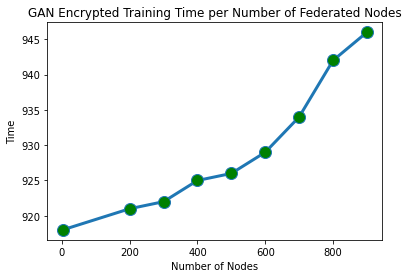

In [59]:
plt.plot(no_of_nodes, encrypted_time, linewidth=3, marker='o', markerfacecolor='green', markersize=12)
plt.xlabel('Number of Nodes')
plt.ylabel('Time')
plt.title('GAN Encrypted Training Time per Number of Federated Nodes')

Text(0.5, 1.0, 'GAN Training Time per Number of Federated Nodes')

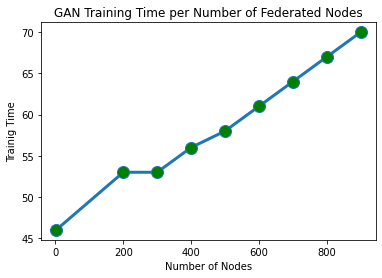

In [64]:
plt.plot(no_of_nodes, normal_time, linewidth=3, marker='o', markerfacecolor='green', markersize=12)
plt.xlabel('Number of Nodes')
plt.ylabel('Trainig Time')
plt.title('GAN Training Time per Number of Federated Nodes')

Text(0.5, 1.0, 'GAN Training Time per Number of Federated Nodes')

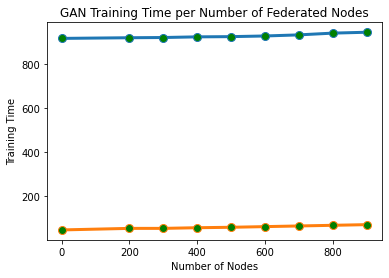

In [65]:
plt.plot(no_of_nodes, encrypted_time, label='E',linewidth=3, marker='o', markerfacecolor='green', markersize=8)
plt.plot(no_of_nodes, normal_time, label='N', linewidth=3, marker='o', markerfacecolor='green', markersize=8)
plt.xlabel('Number of Nodes')
plt.ylabel('Training Time')
plt.title('GAN Training Time per Number of Federated Nodes')